# Ptf Replica

In [42]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Suppress FutureWarnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Load the dataset from an Excel file
path = 'Dataset3_PortfolioReplicaStrategyErrataCorrige.xlsx' # Dataset

# SET EDA_FLAG TRUE to perform exploratory data analysis
EDA_flag = False

# Set the number of trials for the optimization process, if 0 the model run on the trained data
n_trials = 0

In [43]:
import ipywidgets as widgets
from IPython.display import display

# read the name of the selected portfolio
def get_selected_portfolio():
    selected_value = portfolio_selector.value
    if selected_value == 1:
        return "Portfolio Equity"
    elif selected_value == 2:
        return "Portfolio Bond"
    elif selected_value == 3:
        return "Portfolio LifeStrategy 80_20"
    elif selected_value == 0:
        return "NOT A CHOICE"
    else:
        return None

# 2) create a small dropdown or radio‐button selector
opt = {
    "NOT A CHOICE": 0,
    "Portfolio Equity": 1,
    "Portfolio Bond": 2,
    "Portfolio LifeStrategy 80_20": 3,
}

# 1) il selettore delle 3 opzioni
portfolio_selector = widgets.RadioButtons(
    options=[
        ("NOT A CHOICE", 0),
        ("Portfolio Equity", 1),
        ("Portfolio Bond", 2),
        ("Portfolio LifeStrategy", 3),
    ],
    description="Scegli:",
)

# 2) il bottone di conferma
submit_btn = widgets.Button(description="Conferma")

# 3) area di output per log/errori
out = widgets.Output()

# 4) la funzione che viene eseguita solo dopo il click
def on_submit(b):
    with out:
        selected_flag = portfolio_selector.value
        print(f"Hai scelto il portfolio:", get_selected_portfolio())

# 5) colleghiamo il callback
submit_btn.on_click(on_submit)

# 6) mostriamo tutto
display(portfolio_selector, submit_btn, out)

RadioButtons(description='Scegli:', options=(('NOT A CHOICE', 0), ('Portfolio Equity', 1), ('Portfolio Bond', …

Button(description='Conferma', style=ButtonStyle())

Output()

In [45]:
selected_flag = portfolio_selector.value
print("Flag salvato:", get_selected_portfolio())

if selected_flag == 0:
    # disp an error message if no portfolio is selected
    raise ValueError("Invalid portfolio selection. Please select a valid portfolio. AND RE-RUN THE THE CODE FROM THIS CELL ONWARDS.")

Flag salvato: Portfolio Equity


In [46]:
# Read the Excel file, and save the names of the assets (row 4)
full_names_df = pd.read_excel(path, header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Read Bloomberg tickers (row 6)
tickers_df = pd.read_excel(path, header=None, skiprows=5, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Create a dictionary mapping tickers to full names
variable_info = dict(zip(tickers, full_names))

# Read the actual data without using any row as a header
data_raw = pd.read_excel(path, header=None, skiprows=6)

# cut the data before the 01/01/2017 #####################################################################################################################################################
data_raw = data_raw[data_raw[0] >= '2013-01-01']  # Filter rows based on the date column

# First column is the date column
data_raw.columns = ['Date'] + tickers  # Assign the columns correctly using tickers

# Set the date column as the index and ensure it's in datetime format
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d/%m/%Y')
data = data_raw.set_index('Date')

# cCreate a dictionary to hold the index components based on the selected portfolio, and a DataFrame to hold the target data
if selected_flag == 1: # Portfolio Equity
    # EQUITY ETF
    index_components = {
        'MXWO Index': 1
    }
    df_target = data[['MXWO Index']].copy()  # Select the 'MXWO Index' column for further processing

    # VaR parameters - in the equity case, we assume a higher risk profile
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.12  # 20% maximum VaR(1%, 1 month)

elif selected_flag == 2: # Portfolio Bond
    # BOND ETF
    index_components = {
        'LEGATRUU Index': 1
    }
    df_target = data[['LEGATRUU Index']].copy()  # Select the 'LEGATRUU Index' column for further processing
    
    # VaR parameters
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)

elif selected_flag == 3: # Portfolio LifeStrategy 80/20
    # LIFE STRATEGY ETF
    index_components = {
        'MXWO Index': 0.5,
        'LEGATRUU Index': 0.5,
    }
    df_target = data[['MXWO Index', 'LEGATRUU Index']].copy()  # Select the 'MXWO Index' column for further processing

    # VaR parameters
    var_confidence = 0.01  # 1% VaR
    var_horizon = 4  # 4 weeks (1 month)
    max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)
else:
    raise ValueError("Invalid portfolio selection. Please select a valid portfolio.")

# Create a DataFrame to hold the the underlyings
futures_contracts = [
    'RX1 Comdty', 'TY1 Comdty', 'GC1 Comdty', 'CO1 Comdty',
    'ES1 Comdty', 'VG1 Comdty', 'NQ1 Comdty',
    'TP1 Comdty', 'DU1 Comdty', 'TU2 Comdty'
]
df_underlyings = data[futures_contracts].copy()  # Create an empty DataFrame to hold the underlyings

# Transaction costs
# transaction_cost = 0.0005  # 0.05% transaction costs
# transaction_cost = 0.0

if selected_flag == 1:  # Portfolio Equity
    transaction_cost = 0.0005  # 0.05% transaction costs for equity
elif selected_flag == 2:
    transaction_cost = 0.0
elif selected_flag == 3:
    transaction_cost = 0.0005
else:
    raise ValueError("Invalid portfolio selection. Please select a valid portfolio.")


annual_factor = 52  # Number of weeks in a year, to be set following the data frequency

# Create a dictionary to hold the VaR parameters
var_parameters = {
    'var_confidence': var_confidence,
    'var_horizon': var_horizon,
    'max_var_threshold': max_var_threshold
}

index_name_str = ', '.join(index_components.keys())

In [47]:
from ReplicaClass import PortfolioReplicator

rep = PortfolioReplicator(df_target, index_components, df_underlyings, 
                          var_parameters, transaction_cost, annual_factor, name = f"{get_selected_portfolio()}")

# display(pd.concat([rep._y, rep._X], axis=1).head())
# display(pd.concat([rep._y, rep._X], axis=1).describe())

In [48]:
# EDA_flag = True -> perform exploratory data analysis
if EDA_flag:
    rep.plot_cumulative_returns()


    target_fin_stats, underlyings_fin_stats = rep.fin_stats()
    display(target_fin_stats)
    display(underlyings_fin_stats)


    rep.corr_map()


    rep.return_distribution()


    rep.plot_log_returns()


    rolling_window = 52  # 1 year rolling window
    rep.plot_rolling_correlation(window=rolling_window)


    rep.bar_corr_target_underlyings()


    rep.normality_check()


    rep.stationarity_check()
else:
    print("Exploratory Data Analysis is skipped. Set EDA_flag to True to perform EDA.")

Exploratory Data Analysis is skipped. Set EDA_flag to True to perform EDA.


# Equally Weighted Portfolio Replication

In this section, we implement and evaluate an equally weighted portfolio replication strategy using the `PortfolioReplicator` class. The model assigns equal weights to all underlying assets over a rolling window and aims to replicate the performance of the selected target portfolio.

The code below:
- Runs the equally weighted portfolio strategy with a specified rolling window.
- Computes key performance metrics such as information ratio, correlation, tracking error, Sharpe ratio, average gross exposure, and average Value at Risk (VaR).
- Displays a summary table comparing the replica portfolio to the target portfolio across several risk and return metrics.
- Visualizes the results to provide a baseline for comparison with more advanced replication methods.

This equally weighted approach serves as a benchmark to assess the effectiveness of more sophisticated portfolio replication techniques introduced later in the notebook.


Metrics for Equally Weighted Portfolio:


,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
0,-0.531319,0.826816,0.08671,0.888259,1.0,NaN



Detailed metrics for Equally Weighted vs Target:


,Metric,Target,Replica
0,Annualized return,12.99%,8.38%
1,Annualized volatility,14.66%,9.44%
2,Sharpe ratio,0.89,0.89
3,Max Drawdown,28.04%,17.36%
4,Tracking Error,N/A,8.67%
5,Information ratio,N/A,-0.53
6,Correlation,N/A,0.8268
7,Average gross exposure,N/A,1.0000
8,"Average VaR (1%, 1M)",N/A,nan%


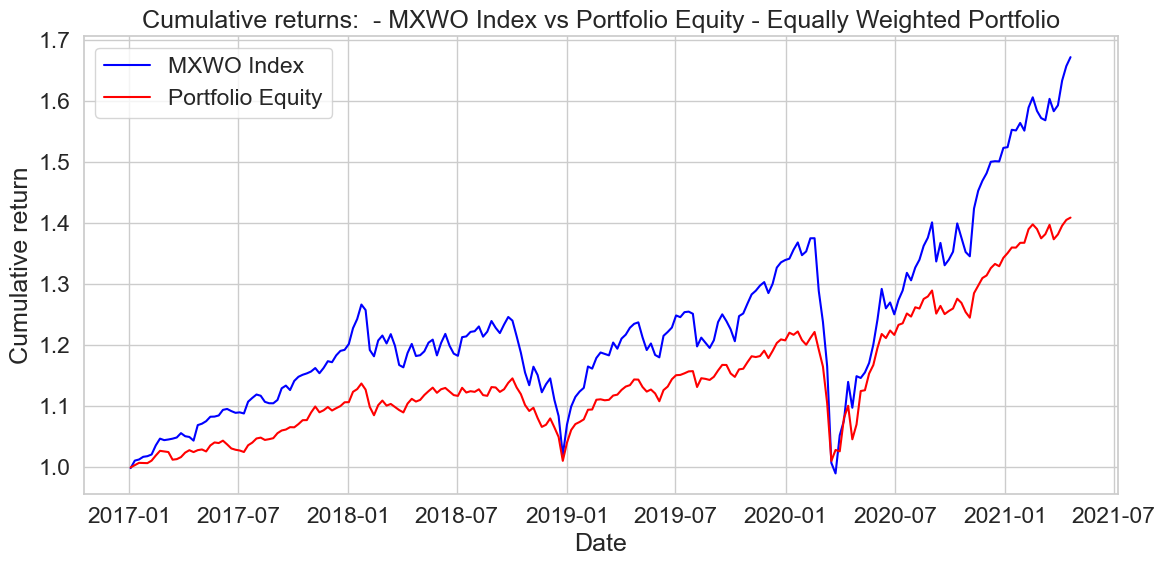

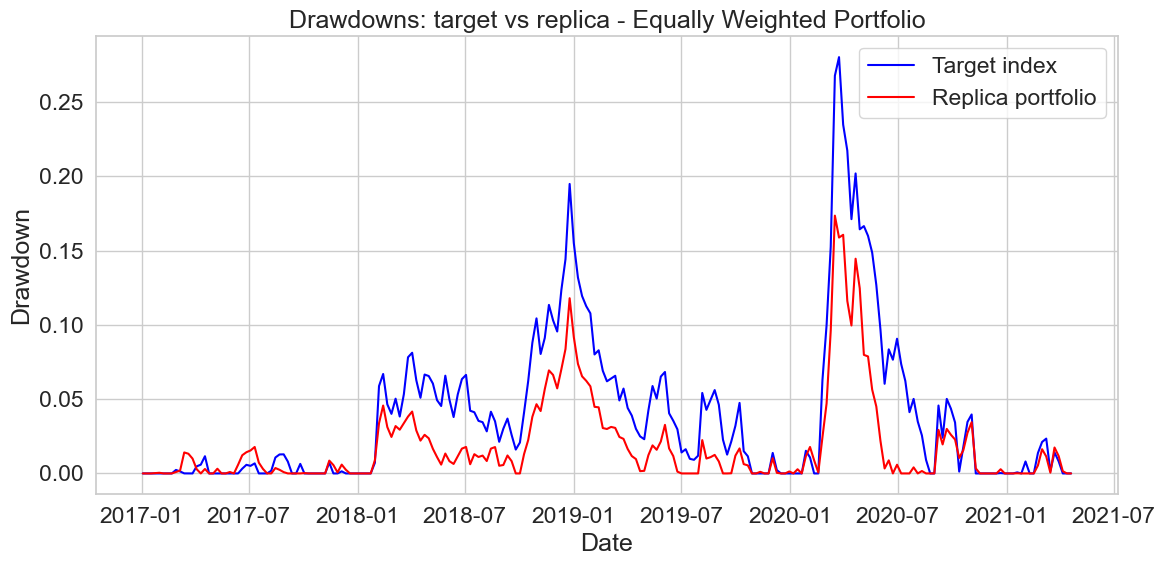

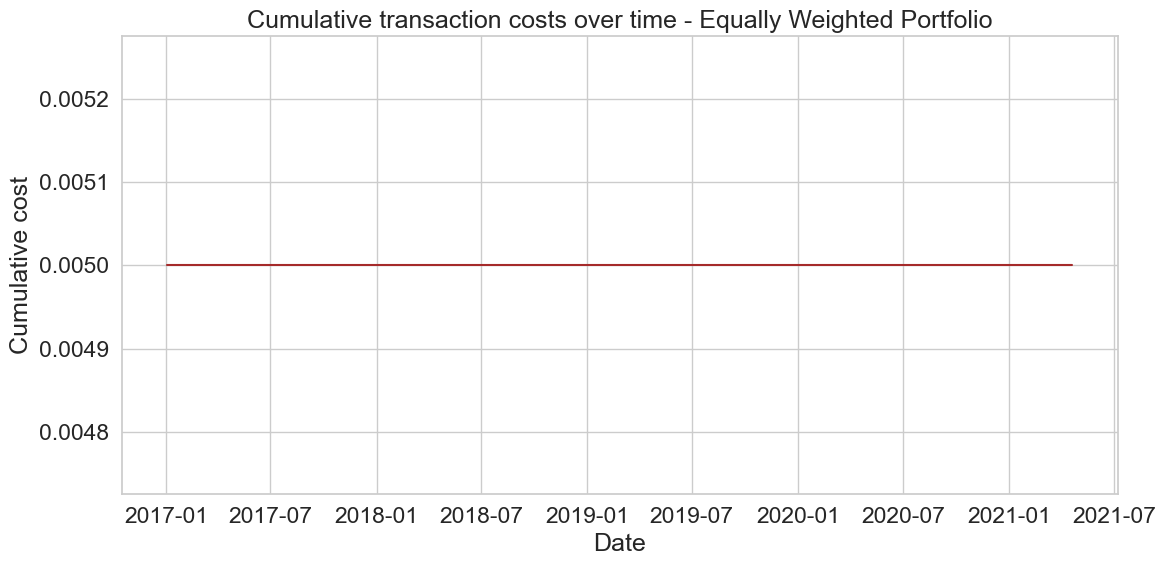

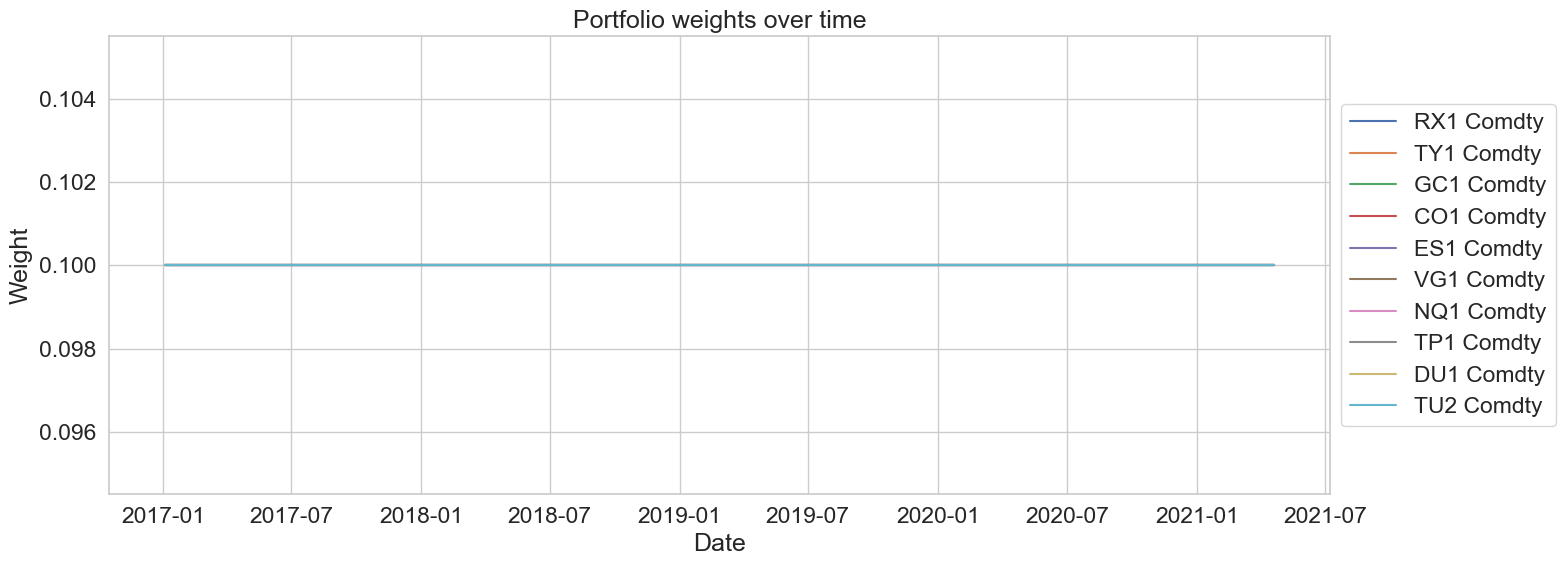

In [49]:
# Param
window = 208

results_equal_weighted = rep.run_equal_weight_portfolio(window)

# Create a DataFrame for the results
result_equal_weighted_df = pd.DataFrame([results_equal_weighted])

# Display the results
print("\nMetrics for Equally Weighted Portfolio:")
display(result_equal_weighted_df[['information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))
 
# Extract the first row for detailed metrics
result_equal_weighted_df = result_equal_weighted_df.iloc[0]

# Create detailed metrics table for the LR configuration
metrics_normalized_equal_weighted = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{result_equal_weighted_df['target_return']*100:.2f}%",
               f"{result_equal_weighted_df['target_vol']*100:.2f}%",
               f"{result_equal_weighted_df['target_sharpe']:.2f}",
               f"{result_equal_weighted_df['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{result_equal_weighted_df['replica_return']*100:.2f}%",
                f"{result_equal_weighted_df['replica_vol']*100:.2f}%",
                f"{result_equal_weighted_df['replica_sharpe']:.2f}",
                f"{result_equal_weighted_df['max_drawdown']*100:.2f}%",
                f"{result_equal_weighted_df['tracking_error']*100:.2f}%",
                f"{result_equal_weighted_df['information_ratio']:.2f}",
                f"{result_equal_weighted_df['correlation']:.4f}",
                f"{result_equal_weighted_df['avg_gross_exposure']:.4f}",
                f"{result_equal_weighted_df['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for Equally Weighted vs Target:")
display(metrics_normalized_equal_weighted)

# Plot the results for the Linear Regression model
rep.plot_metrics(result_equal_weighted_df, 'Equally Weighted Portfolio')

# Elastic Net Portfolio Replication

In this section, we implement and evaluate a portfolio replication strategy using the Elastic Net regression model. Elastic Net is a regularized regression technique that linearly combines the penalties of Lasso (L1) and Ridge (L2) methods. This approach is particularly useful when dealing with highly correlated features, as it encourages both sparsity and grouping effects in the portfolio weights.

**Theory Snapshot:**  
Elastic Net regression solves the following optimization problem:

$$
\min_{\beta} \left\{ \frac{1}{2n} \| y - X\beta \|^2_2 + \alpha \left( \lambda \|\beta\|_1 + \frac{1-\lambda}{2} \|\beta\|_2^2 \right) \right\}
$$

where $\alpha$ controls the overall strength of regularization and $\lambda$ determines the mix between L1 and L2 penalties.

**What this cell does:**
- Runs an Optuna hyperparameter search to find the best Elastic Net configuration for portfolio replication.
- Trains the Elastic Net model using the optimal parameters.
- Computes and displays key performance metrics for the replica portfolio, including information ratio, correlation, tracking error, Sharpe ratio, average gross exposure, and average VaR.
- Presents a detailed comparison table between the target and replica portfolios.
- Visualizes the performance of the Elastic Net-based replica portfolio.

This method provides a more flexible and potentially more robust alternative to the equally weighted benchmark, especially in the presence of multicollinearity among the underlying assets.

In [50]:

# 3) Run Optuna search, depending on the selected portfolio we differentiate the storage aand name of the study
name = get_selected_portfolio()
# the storage name wll be EN_PtfName and is in the foalder called with the name of the portfolio
folder_name = f"{name.replace(' ', '_')}"  # e.g., EN_Portfolio_Equity
storage_name = f"EN_{name.replace(' ', '_')}"  # e.g., optuna_Portfolio_Equity
stu_name = f"EN_{name.replace(' ', '_')}_study"  # e.g., Portfolio_Equity_study

storage_dir = Path.cwd() / folder_name
storage_dir.mkdir(parents=True, exist_ok=True)

# 2) build the full sqlite URL
storage_path = f"./{folder_name}/{storage_name}"

study_EN = rep.run_optuna_normalized(
    n_trials=n_trials,
    storage=storage_path,
    study_name=stu_name,
    obj = rep._optuna_objective_EN
)

[I 2025-05-31 18:30:36,173] Using an existing study with name 'EN_Portfolio_Equity_study' instead of creating a new one.



Top Optuna configuration by information ratio:


,l1_ratio,rolling_window,alpha,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
0,0.99991,208,0.007887,0.354087,0.955391,0.044039,1.102278,0.856044,0.07555



Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,12.99%,14.55%
1,Annualized volatility,14.66%,13.20%
2,Sharpe ratio,0.89,1.10
3,Max Drawdown,28.04%,20.15%
4,Tracking Error,N/A,4.40%
5,Information ratio,N/A,0.35
6,Correlation,N/A,0.9554
7,Average gross exposure,N/A,0.8560
8,"Average VaR (1%, 1M)",N/A,7.55%


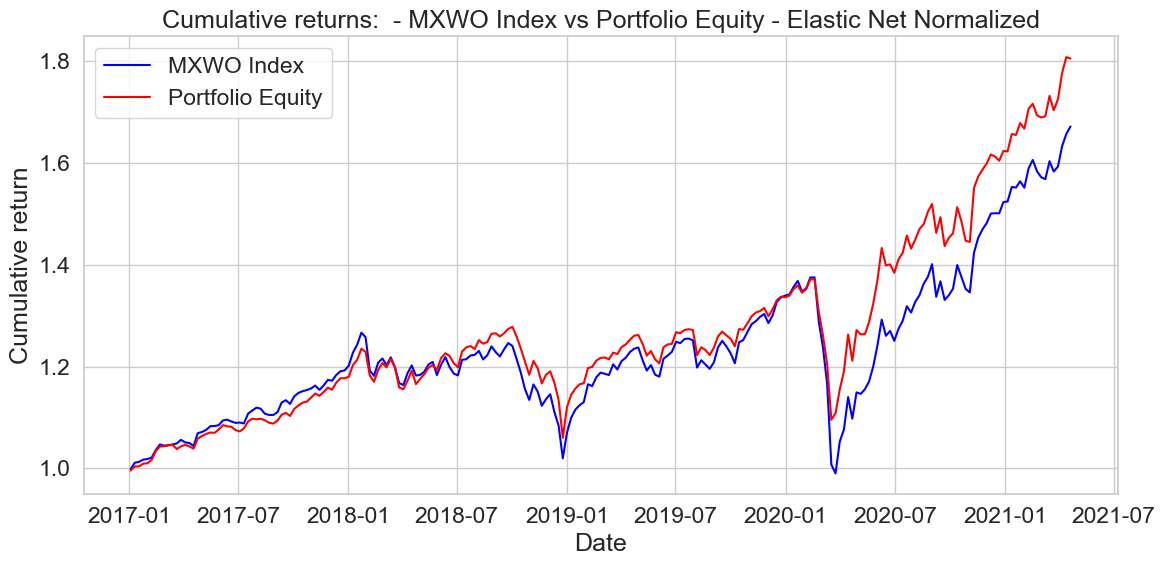

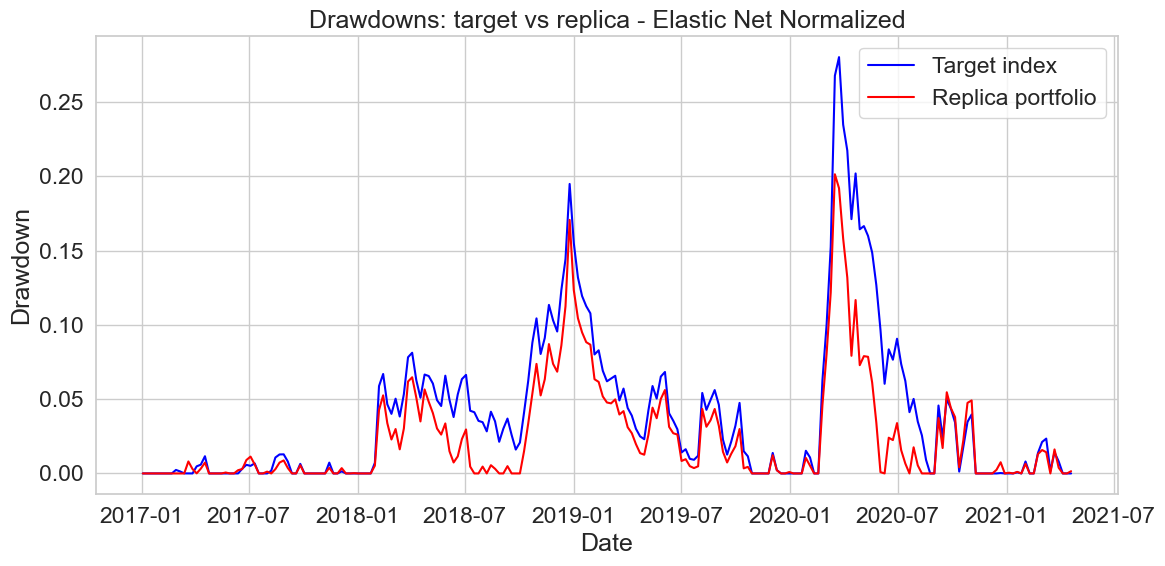

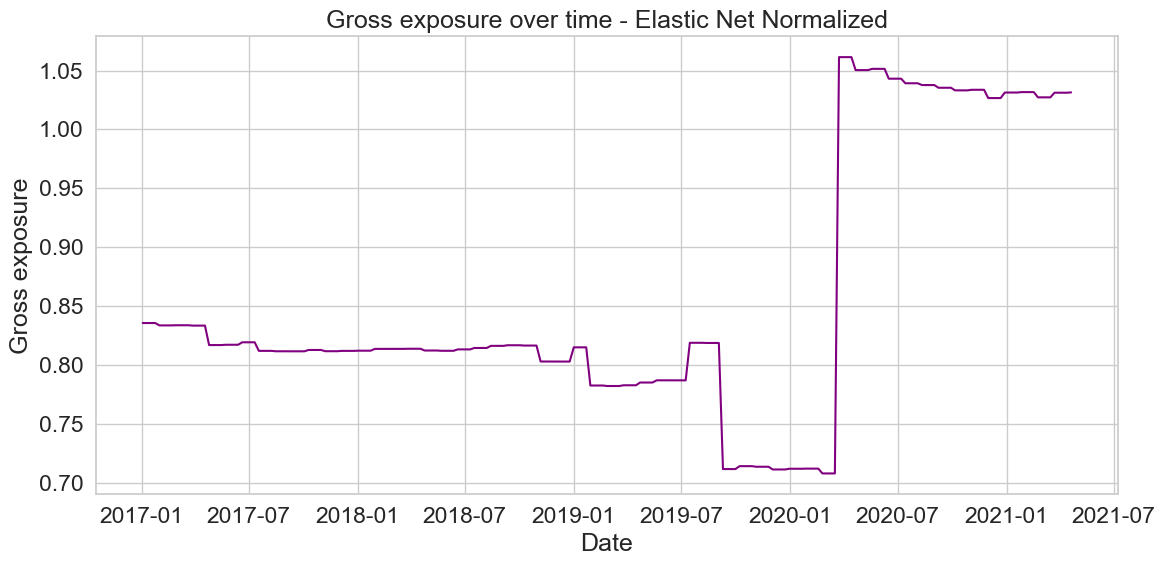

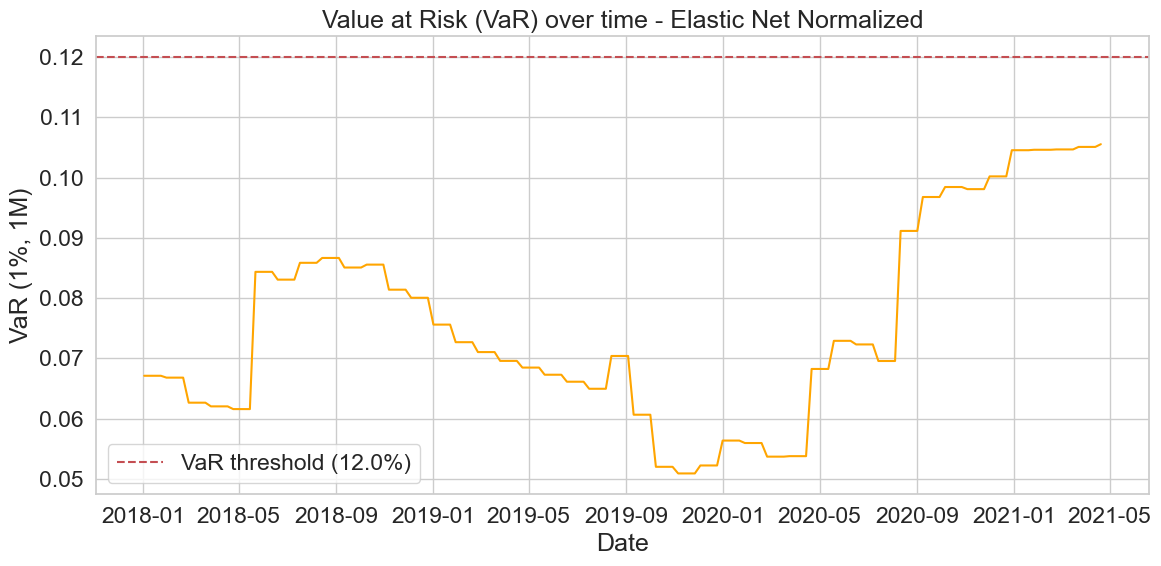

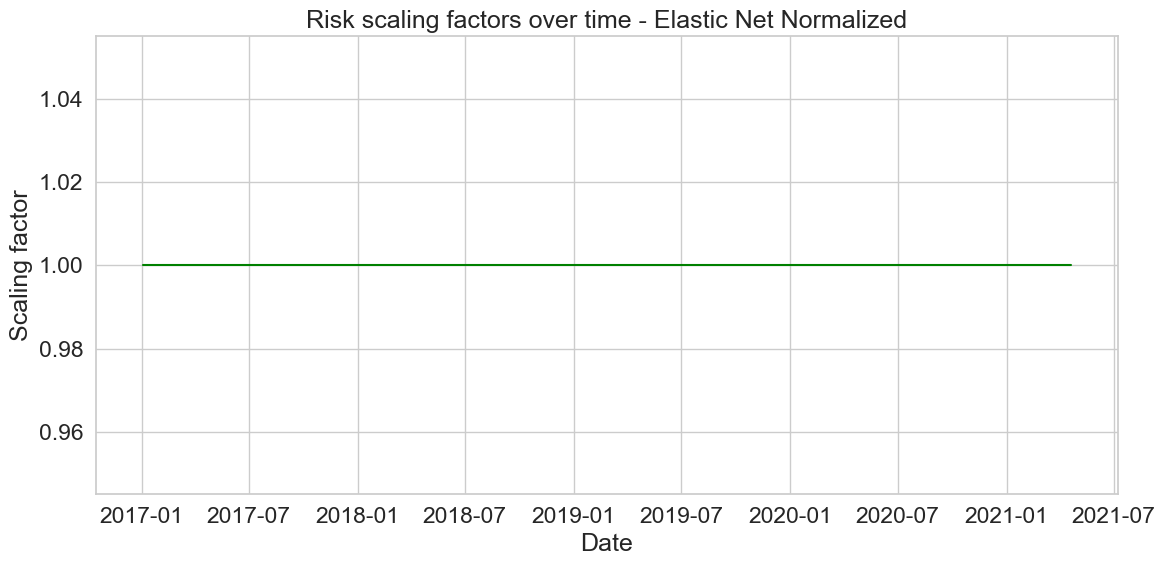

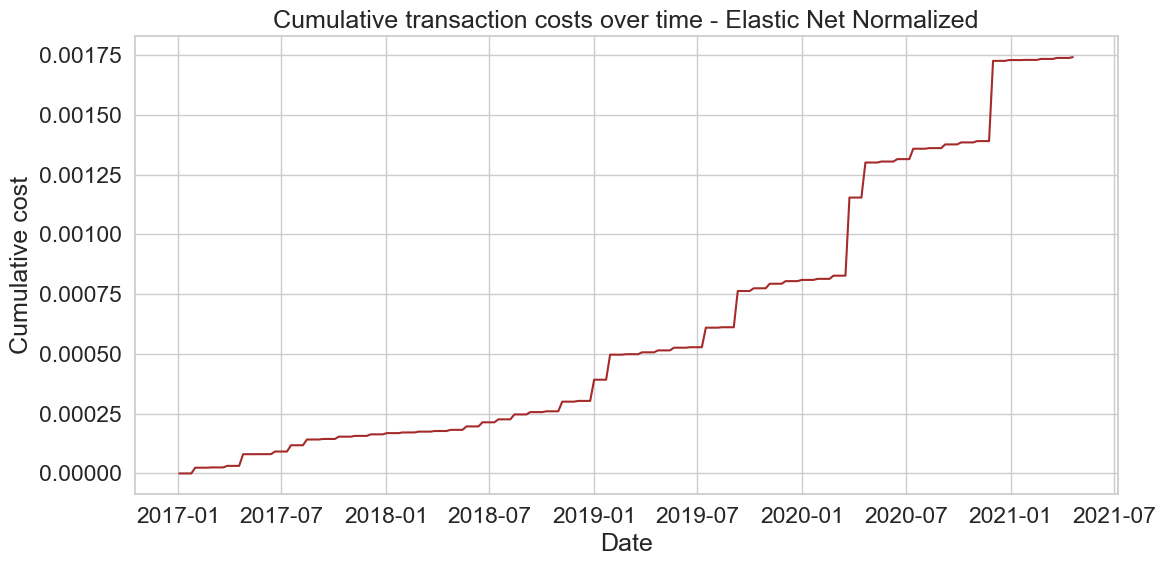

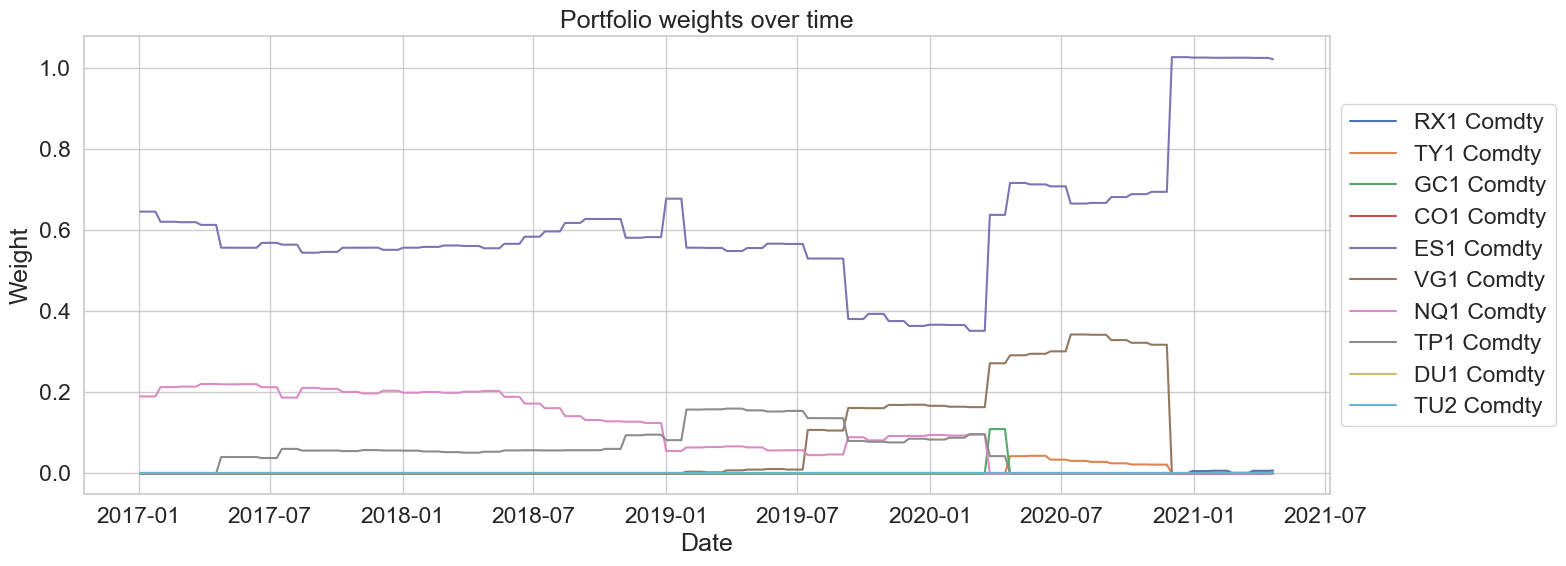

In [51]:
results_normalized_EN = []

best = study_EN.best_params
l1_ratio = best["l1_ratio"]
rolling_window = best["rolling_window"]
alpha = best["alpha"]
rebalancing_window = best["rebalancing_window"]

results_EN = rep.run_elasticnet_normalized(l1_ratio, rolling_window, alpha,rebalancing_window)
results_normalized_EN.append(results_EN)

# Convert results to DataFrame for easier analysis
results_df_normalized_EN = pd.DataFrame(results_normalized_EN)

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(results_df_normalized_EN[['l1_ratio', 'rolling_window', 'alpha', 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(10))

best_config_normalized_EN = results_df_normalized_EN.iloc[0]

# Create detailed metrics table for the best configuration
metrics_normalized_EN = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_EN['target_return']*100:.2f}%",
               f"{best_config_normalized_EN['target_vol']*100:.2f}%",
               f"{best_config_normalized_EN['target_sharpe']:.2f}",
               f"{best_config_normalized_EN['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_EN['replica_return']*100:.2f}%",
                f"{best_config_normalized_EN['replica_vol']*100:.2f}%",
                f"{best_config_normalized_EN['replica_sharpe']:.2f}",
                f"{best_config_normalized_EN['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_EN['tracking_error']*100:.2f}%",
                f"{best_config_normalized_EN['information_ratio']:.2f}",
                f"{best_config_normalized_EN['correlation']:.4f}",
                f"{best_config_normalized_EN['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_EN['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_EN)

# Plot the results for the best configuration
rep.plot_metrics(best_config_normalized_EN, 'Elastic Net Normalized')

# Kalman Filter Portfolio Replication

In this section, we implement and evaluate a portfolio replication strategy using the Kalman Filter model. The Kalman Filter is a recursive algorithm that estimates the state of a dynamic system from a series of noisy measurements. In the context of portfolio replication, it is used to dynamically estimate and update the optimal portfolio weights over time, adapting to changing market conditions.

**Theory Snapshot:**  
The Kalman Filter operates in two main steps: prediction and update. It predicts the next state (portfolio weights) based on the previous state and then updates this prediction using new observed data (asset returns). This approach allows for real-time tracking and adjustment of portfolio weights, making it well-suited for financial time series that exhibit non-stationarity and noise.

**What this cell does:**
- Runs the Kalman Filter-based portfolio replication model with specified rolling and rebalancing windows.
- Computes and displays key performance metrics for the replica portfolio, including information ratio, correlation, tracking error, Sharpe ratio, average gross exposure, and average VaR.
- Presents a detailed comparison table between the target and replica portfolios.
- Visualizes the performance of the Kalman Filter-based replica portfolio.

This method provides a dynamic and adaptive alternative to static or regression-based approaches, potentially improving replication accuracy in volatile or evolving markets.


Top Optuna configuration by information ratio:


,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
0,-0.439961,0.996949,0.01146,0.857925,1.27354,0.073572



Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,12.99%,12.49%
1,Annualized volatility,14.66%,14.55%
2,Sharpe ratio,0.89,0.86
3,Max Drawdown,28.04%,27.98%
4,Tracking Error,N/A,1.15%
5,Information ratio,N/A,-0.44
6,Correlation,N/A,0.9969
7,Average gross exposure,N/A,1.2735
8,"Average VaR (1%, 1M)",N/A,7.36%


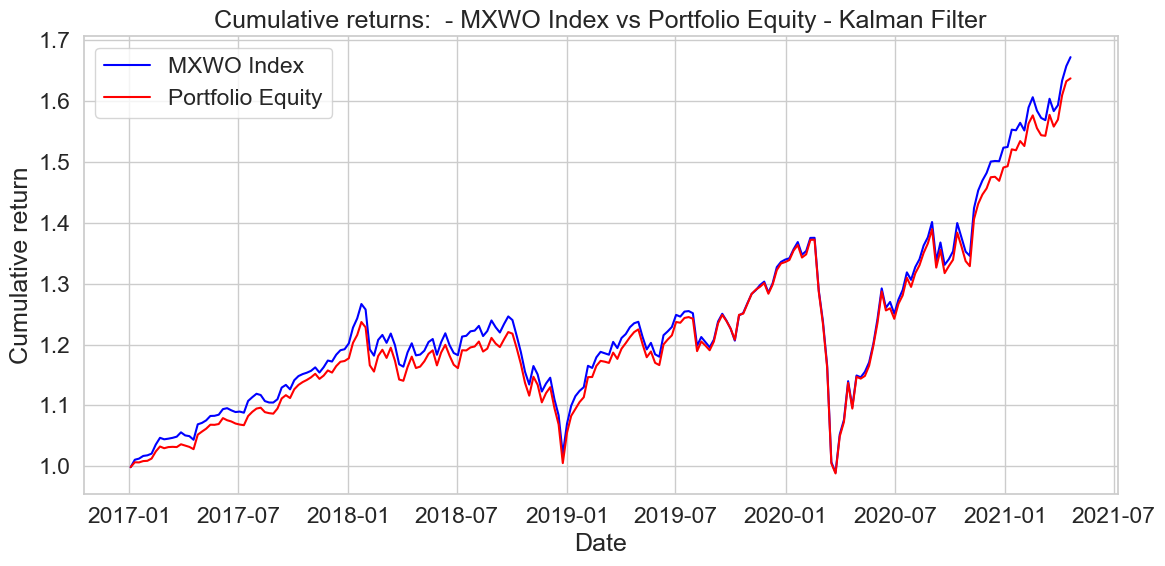

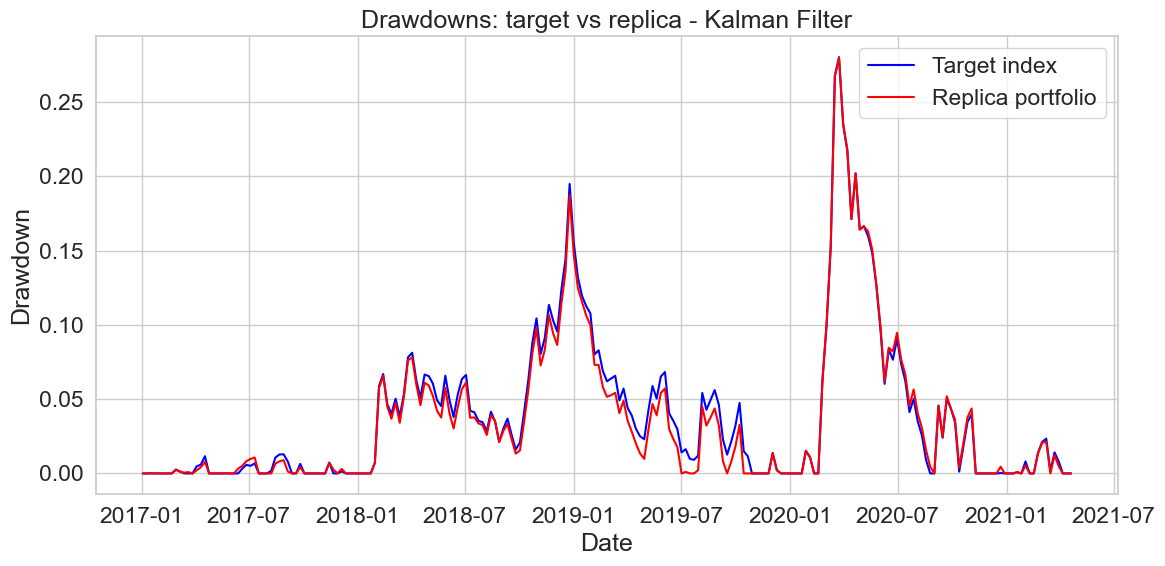

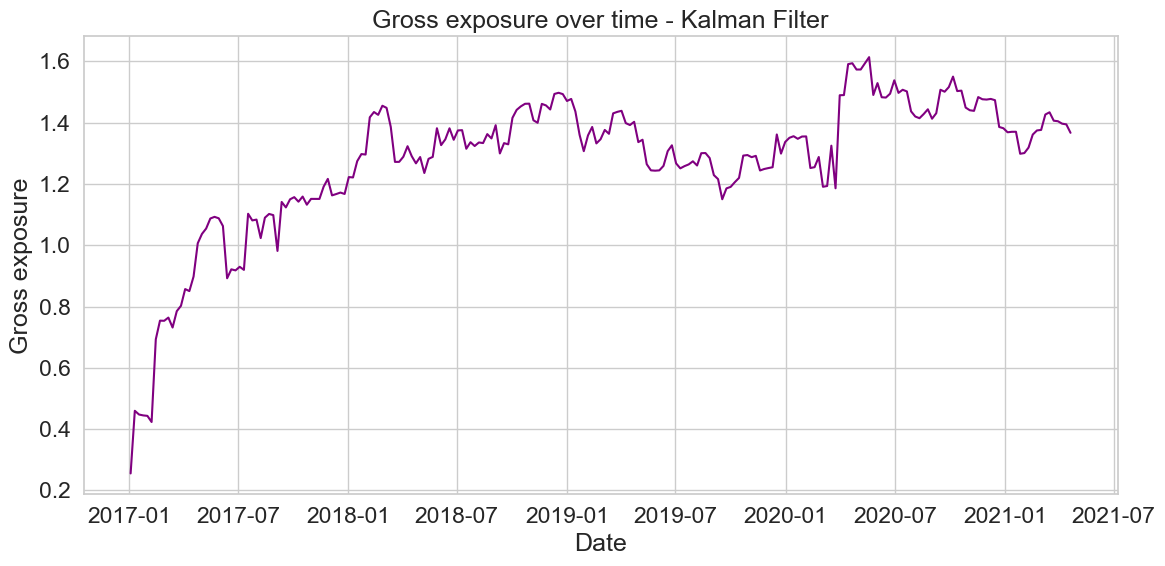

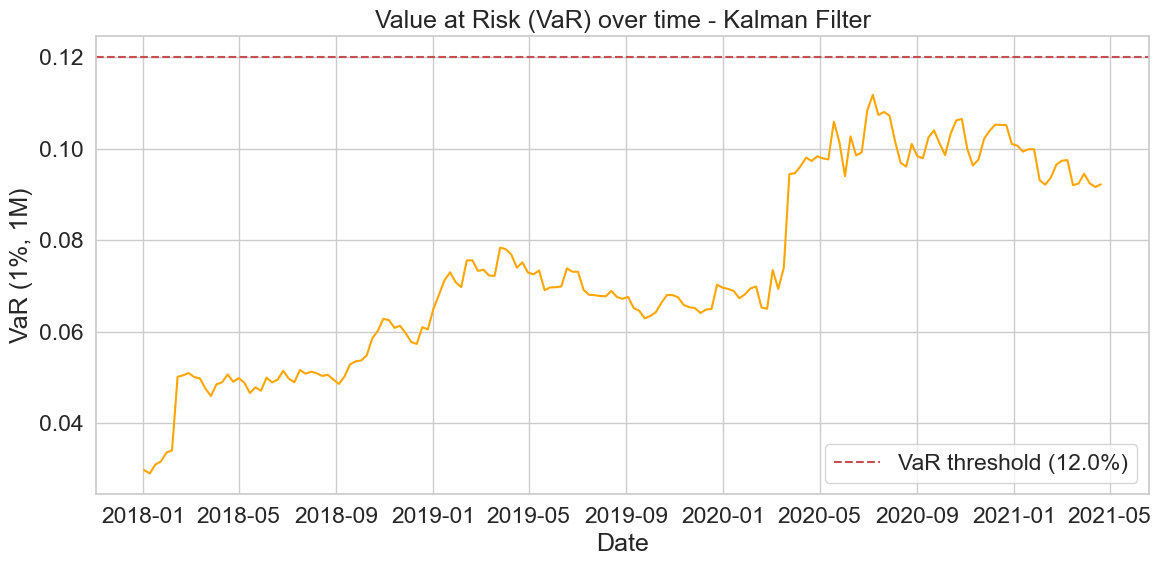

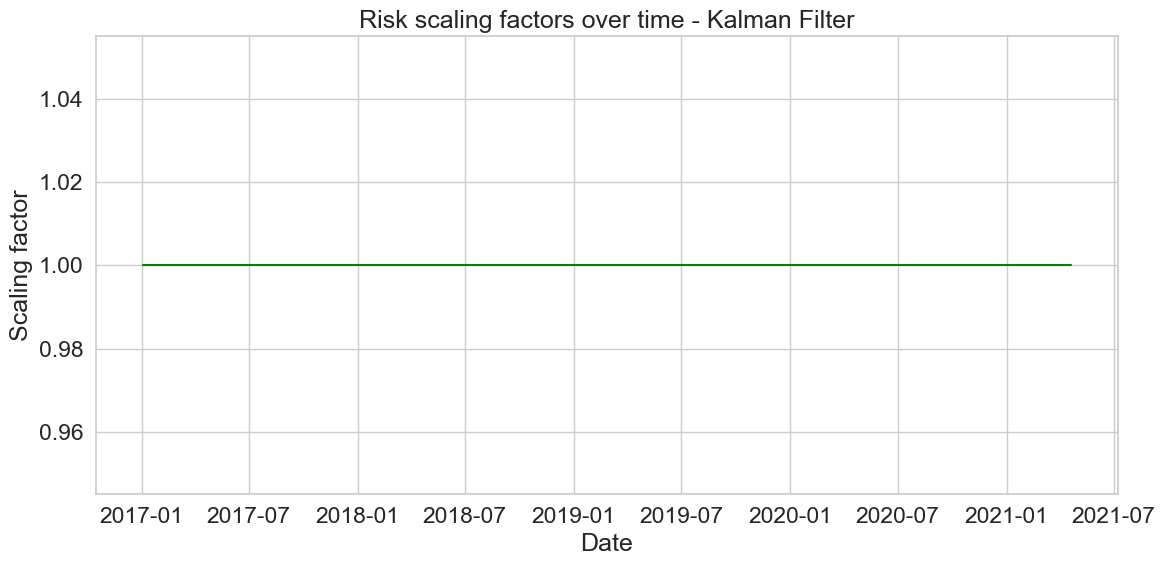

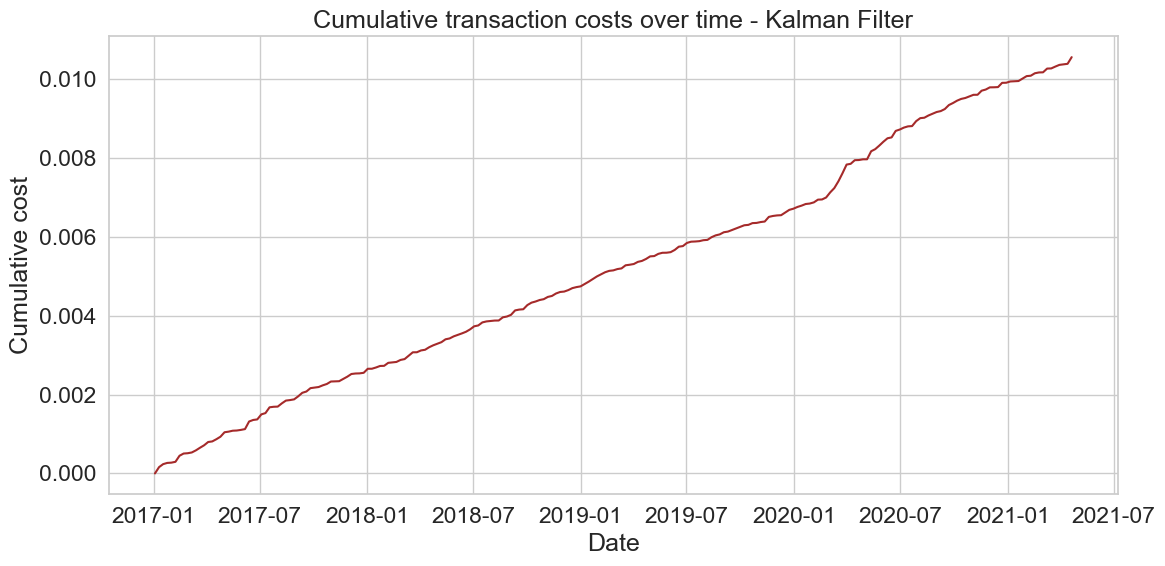

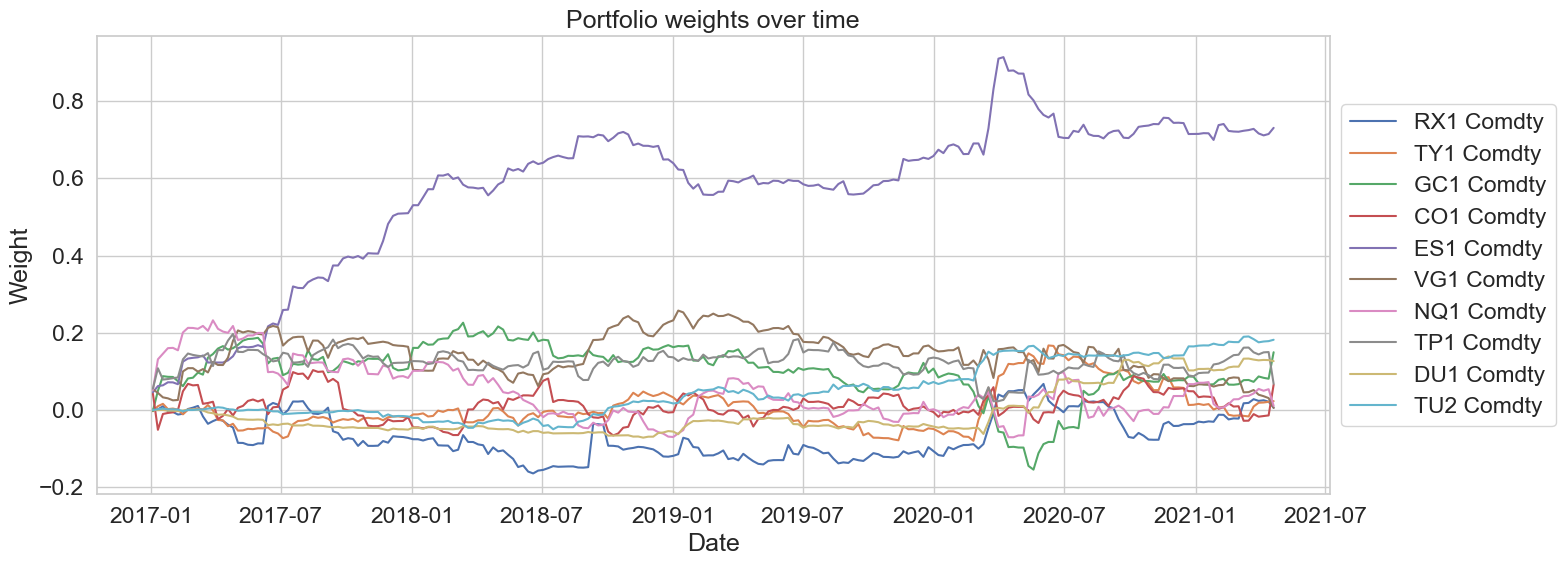

In [52]:
# Run the Kalman filter model
result_KF = rep.run_kalman_filter_model(
    rolling_window=208,               # 1 year rolling window
    rebalancing_window=1            # Weekly rebalancing
)

# Create a DataFrame for the results
result_KF_df = pd.DataFrame([result_KF])

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(result_KF_df[[ 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))

best_config_normalized_KF = result_KF_df.iloc[0]


# Create detailed metrics table for the best configuration
metrics_normalized_KF = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_KF['target_return']*100:.2f}%",
               f"{best_config_normalized_KF['target_vol']*100:.2f}%",
               f"{best_config_normalized_KF['target_sharpe']:.2f}",
               f"{best_config_normalized_KF['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_KF['replica_return']*100:.2f}%",
                f"{best_config_normalized_KF['replica_vol']*100:.2f}%",
                f"{best_config_normalized_KF['replica_sharpe']:.2f}",
                f"{best_config_normalized_KF['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_KF['tracking_error']*100:.2f}%",
                f"{best_config_normalized_KF['information_ratio']:.2f}",
                f"{best_config_normalized_KF['correlation']:.4f}",
                f"{best_config_normalized_KF['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_KF['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_KF)


# Display the results
rep.plot_metrics(result_KF, 'Kalman Filter')

# Ensemble Kalman Filter Portfolio Replication

In this section, we implement and evaluate a portfolio replication strategy using the **Ensemble Kalman Filter (EnKF)** model. The EnKF is an advanced extension of the standard Kalman Filter, designed to handle non-linearities and model uncertainties by propagating an ensemble (collection) of possible state vectors (here, portfolio weights) through time.

**Theory Snapshot:**  
The Ensemble Kalman Filter works by maintaining a set of possible weight vectors (the ensemble), each of which evolves over time according to a random-walk process (process noise). At each rebalancing step:
- Each ensemble member is updated using new observed data (asset returns) via a Kalman update, which adjusts the weights based on the observed error.
- The ensemble mean and covariance are used to estimate the current optimal portfolio weights and their uncertainty.
- This approach allows the model to adapt dynamically to changing market conditions, capturing both the mean and the uncertainty of the optimal weights.

Key steps in the implementation:
- **Initialization:** The process starts with a Ridge regression on the initial rolling window to set the starting weights.
- **Ensemble Propagation:** At each rebalancing date, the weights are updated using the Kalman filter equations, with process noise injected to simulate uncertainty and allow for exploration of different possible weight paths.
- **Observation Update:** The filter incorporates the latest observed return, updating the ensemble of weights accordingly.
- **VaR Scaling:** If the Value at Risk (VaR) exceeds a threshold, the weights are scaled down to control risk.
- **Transaction Costs:** The model accounts for transaction costs based on the turnover in weights.
- **Holding Weights:** On non-rebalancing days, the previous weights are held constant.

**What this cell does:**
- Runs an Optuna hyperparameter search to find the best configuration for the Ensemble Kalman Filter (ensemble size, process noise scale, rolling and rebalancing windows).
- Trains the EnKF model using the optimal parameters.
- Computes and displays key performance metrics for the replica portfolio, including information ratio, correlation, tracking error, Sharpe ratio, average gross exposure, and average VaR.
- Presents a detailed comparison table between the target and replica portfolios.
- Visualizes the performance of the Ensemble Kalman Filter-based replica portfolio.

This method provides a robust and flexible alternative to traditional Kalman Filter and regression-based approaches, especially in environments with high uncertainty, non-linearity, and time-varying relationships between assets.

In [53]:

name = get_selected_portfolio()
# the storage name wll be EN_PtfName and is in the foalder called with the name of the portfolio
folder_name = f"{name.replace(' ', '_')}"  # e.g., EN_Portfolio_Equity
storage_name = f"EKF_{name.replace(' ', '_')}"  # e.g., optuna_Portfolio_Equity
stu_name = f"EKF_{name.replace(' ', '_')}_study"  # e.g., Portfolio_Equity_study

storage_dir = Path.cwd() / folder_name
storage_dir.mkdir(parents=True, exist_ok=True)

storage_path = f"./{folder_name}/{storage_name}"

# 3) Run Optuna search
study_KFE = rep.run_optuna_normalized(
    n_trials=n_trials,
    storage=storage_path,
    study_name=stu_name,
    obj=rep._optuna_objective_KFE
)

[I 2025-05-31 18:30:38,727] Using an existing study with name 'EKF_Portfolio_Equity_study' instead of creating a new one.



Top Optuna configuration by information ratio:


,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
0,-0.310062,0.973269,0.034431,0.880113,1.300922,0.070663



Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,12.99%,11.92%
1,Annualized volatility,14.66%,13.55%
2,Sharpe ratio,0.89,0.88
3,Max Drawdown,28.04%,23.87%
4,Tracking Error,N/A,3.44%
5,Information ratio,N/A,-0.31
6,Correlation,N/A,0.9733
7,Average gross exposure,N/A,1.3009
8,"Average VaR (1%, 1M)",N/A,7.07%


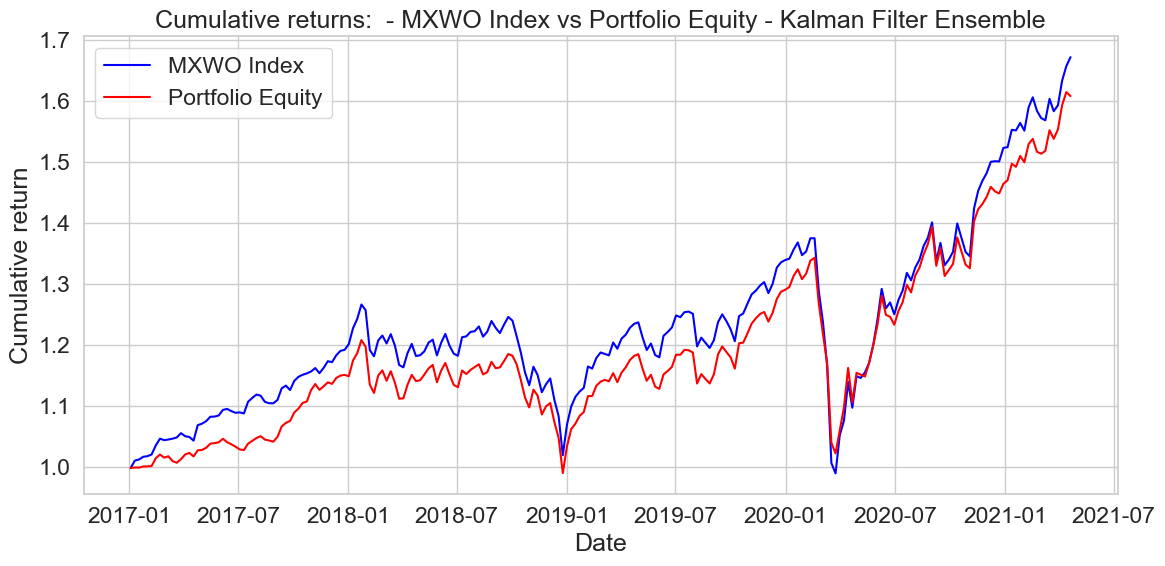

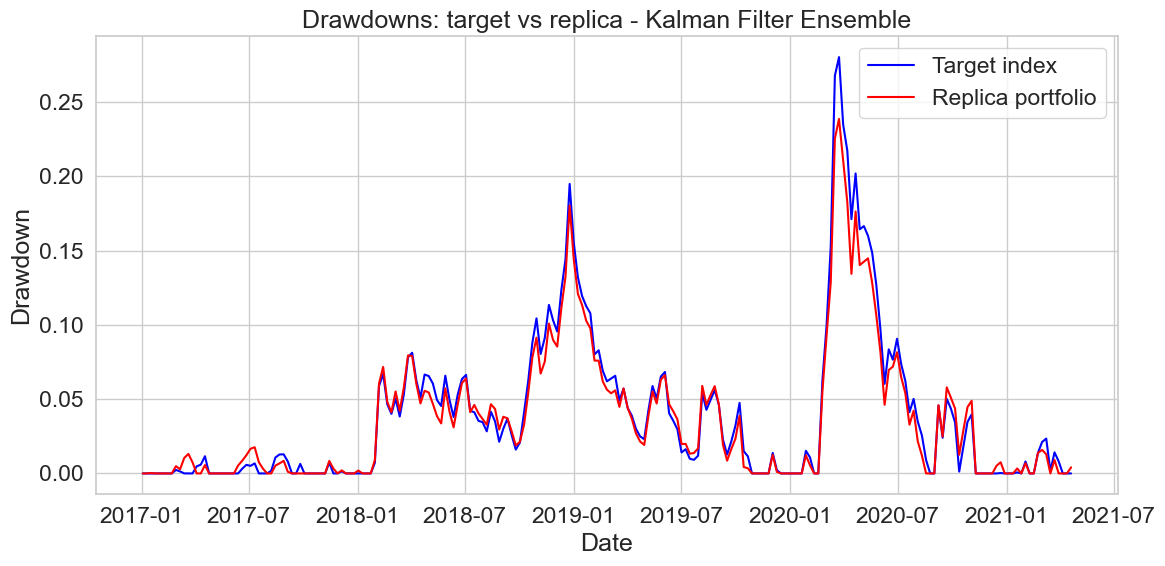

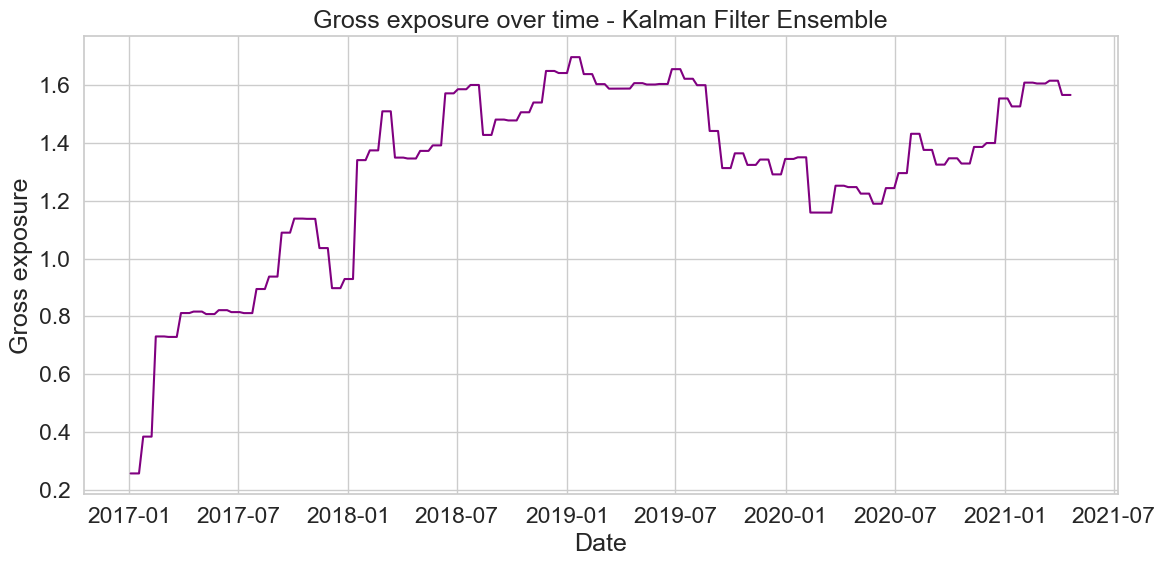

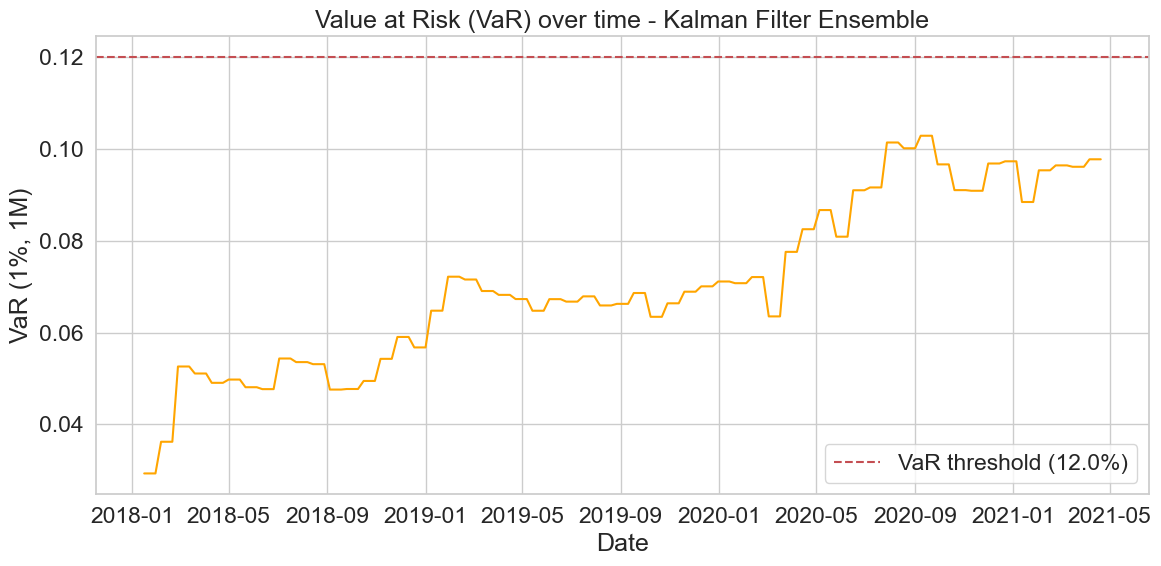

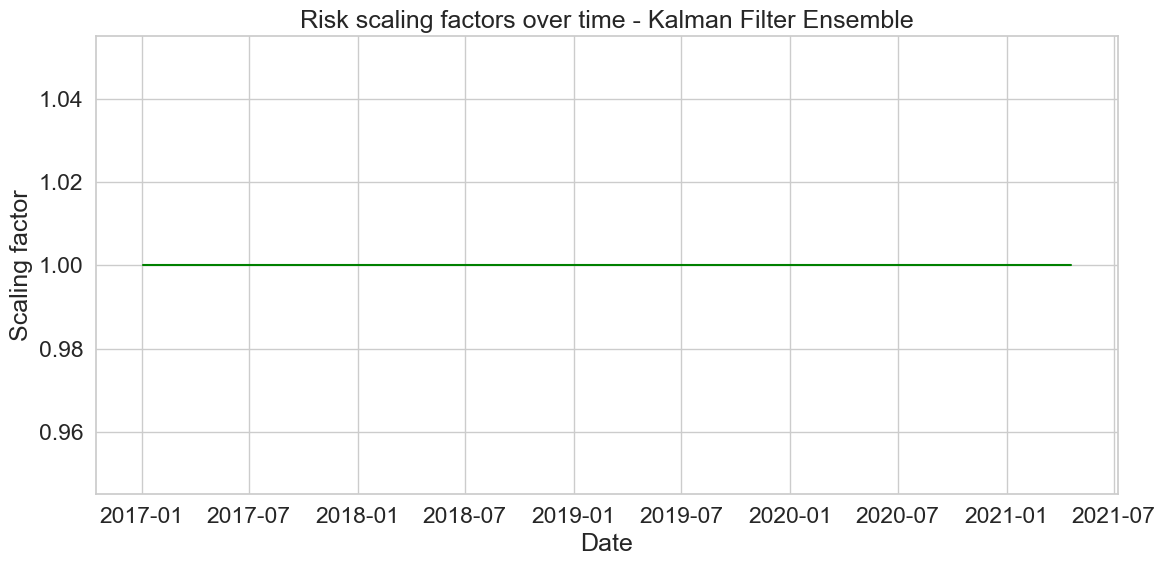

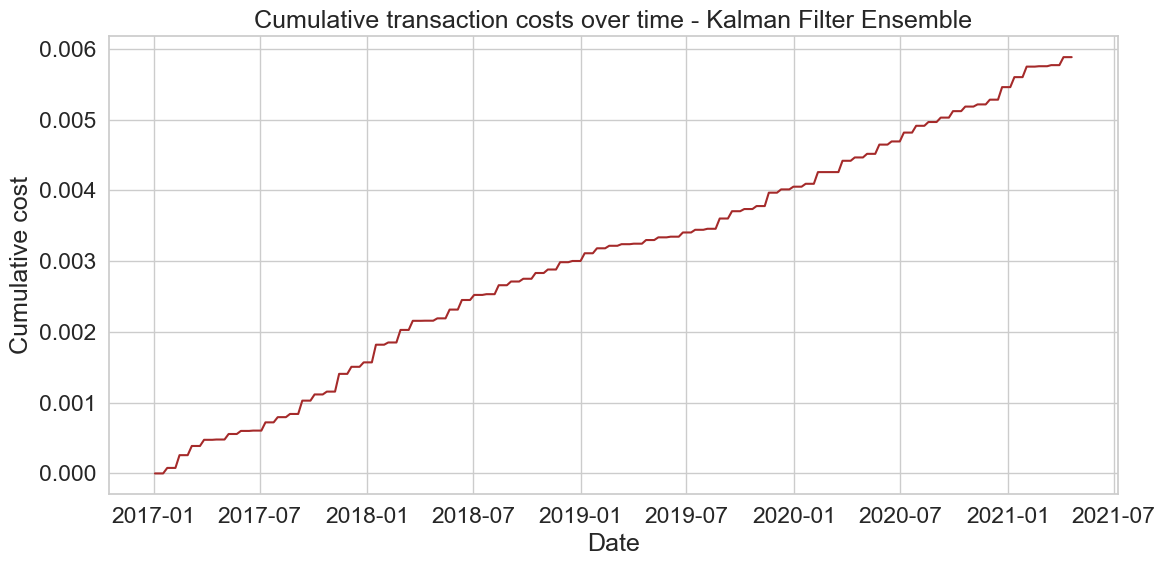

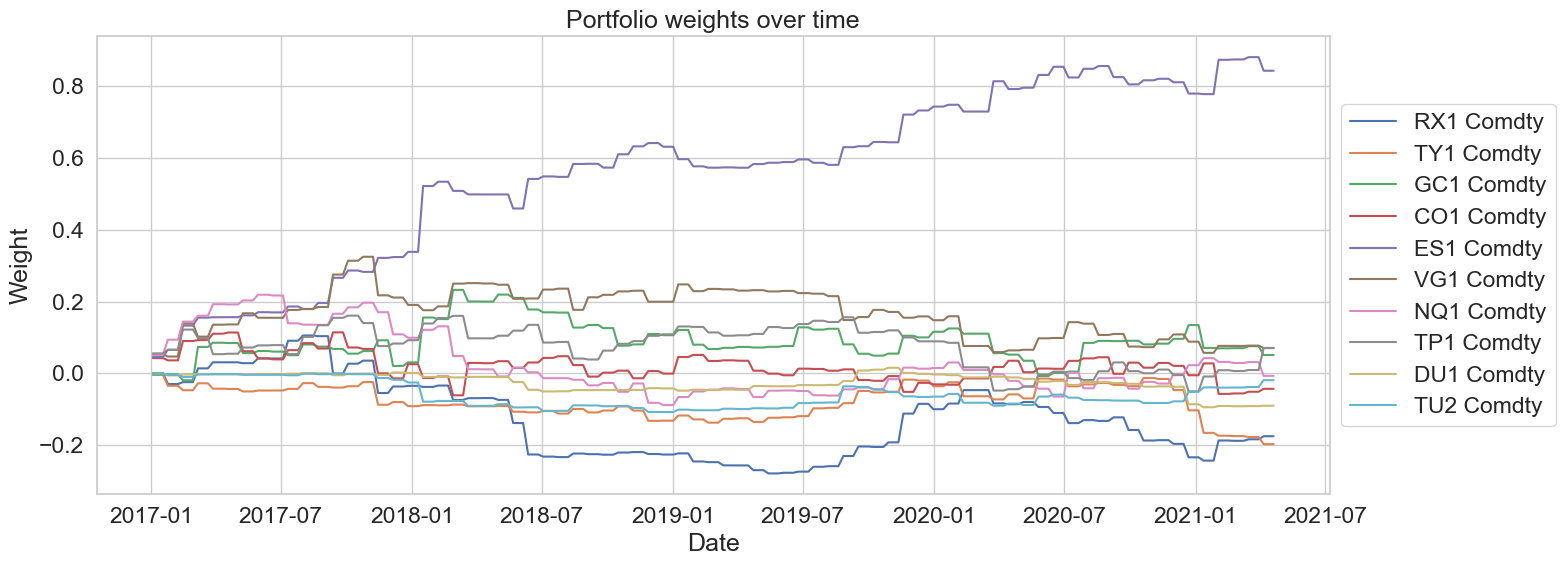

In [54]:
# # Import best parameters from optuna
ensemble_size = study_KFE.best_trial.params['ensemble_size']
process_noise_scale = study_KFE.best_trial.params['process_noise_scale']
rolling_window = study_KFE.best_trial.params['rolling_window']
rebalancing_window = study_KFE.best_trial.params['rebalancing_window']


# Run the Kalman filter model
result_KFE = rep.run_ensemble_kalman_filter_model(
    rolling_window=rolling_window,               
    rebalancing_window=rebalancing_window,       
    ensemble_size=ensemble_size,                 # Ensemble size from Optuna
    process_noise_scale=process_noise_scale      # Process noise scale from Optuna
)

# Create a DataFrame for the results
result_KFE_df = pd.DataFrame([result_KFE])

# Display top configuration by information ratio
print("\nTop Optuna configuration by information ratio:")
display(result_KFE_df[[ 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(1))

best_config_normalized_KFE = result_KFE_df.iloc[0]


# Create detailed metrics table for the best configuration
metrics_normalized_KFE = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized_KFE['target_return']*100:.2f}%",
               f"{best_config_normalized_KFE['target_vol']*100:.2f}%",
               f"{best_config_normalized_KFE['target_sharpe']:.2f}",
               f"{best_config_normalized_KFE['target_max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized_KFE['replica_return']*100:.2f}%",
                f"{best_config_normalized_KFE['replica_vol']*100:.2f}%",
                f"{best_config_normalized_KFE['replica_sharpe']:.2f}",
                f"{best_config_normalized_KFE['max_drawdown']*100:.2f}%",
                f"{best_config_normalized_KFE['tracking_error']*100:.2f}%",
                f"{best_config_normalized_KFE['information_ratio']:.2f}",
                f"{best_config_normalized_KFE['correlation']:.4f}",
                f"{best_config_normalized_KFE['avg_gross_exposure']:.4f}",
                f"{best_config_normalized_KFE['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized_KFE)

# Plot the results for the best configuration
rep.plot_metrics(best_config_normalized_KFE, 'Kalman Filter Ensemble')

# Model Comparison and Analysis

In this section, we compare the performance of all implemented portfolio replication strategies: Equally Weighted, Elastic Net, Kalman Filter, and Ensemble Kalman Filter. The comparison is based on a comprehensive set of risk and return metrics, including annualized return, volatility, Sharpe ratio, maximum drawdown, tracking error, information ratio, correlation, average gross exposure, and average Value at Risk (VaR).

**What this cell does:**
- Aggregates the key performance metrics for each model into a single DataFrame for side-by-side comparison.
- Displays the comparison table to highlight the strengths and weaknesses of each approach relative to the target portfolio.
- Provides a clear overview to support the selection of the most effective replication strategy under different market conditions.

This analysis helps to identify which model best replicates the target portfolio and under what circumstances each method may be preferred.

In [55]:
# Build full comparison table
# window=52

all_models_metrics = [
    rep.extract_target_metrics(window),
    rep.extract_replica_metrics(results_equal_weighted, 'Equally Weighted'),
    rep.extract_replica_metrics(results_df_normalized_EN.iloc[0].to_dict(), 'Elastic Net Normalized'),
    rep.extract_replica_metrics(best_config_normalized_KF.to_dict(), 'Kalman Filter'),
    rep.extract_replica_metrics(best_config_normalized_KFE.to_dict(), 'Ensemble Kalman Filter')
]

comparison_df = pd.DataFrame(all_models_metrics)

# Display
print("\nFull Performance Comparison (with consistent Target Portfolio metrics):")
display(comparison_df)



Full Performance Comparison (with consistent Target Portfolio metrics):


,Model,Annualized return,Annualized volatility,Sharpe ratio,Max Drawdown,Tracking Error,Information ratio,Correlation,Average gross exposure,"Average VaR (1%, 1M)",Transaction cost (bp)
0,Target Portfolio,12.99%,14.66%,0.89,28.04%,N/A,N/A,N/A,N/A,N/A,NaN
1,Equally Weighted,8.38%,9.44%,0.89,17.36%,8.67%,-0.53,0.8268,1.0000,N/A,50.00
2,Elastic Net Normalized,14.55%,13.20%,1.10,20.15%,4.40%,0.35,0.9554,0.8560,7.55%,17.41
3,Kalman Filter,12.49%,14.55%,0.86,27.98%,1.15%,-0.44,0.9969,1.2735,7.36%,105.49
4,Ensemble Kalman Filter,11.92%,13.55%,0.88,23.87%,3.44%,-0.31,0.9733,1.3009,7.07%,58.85


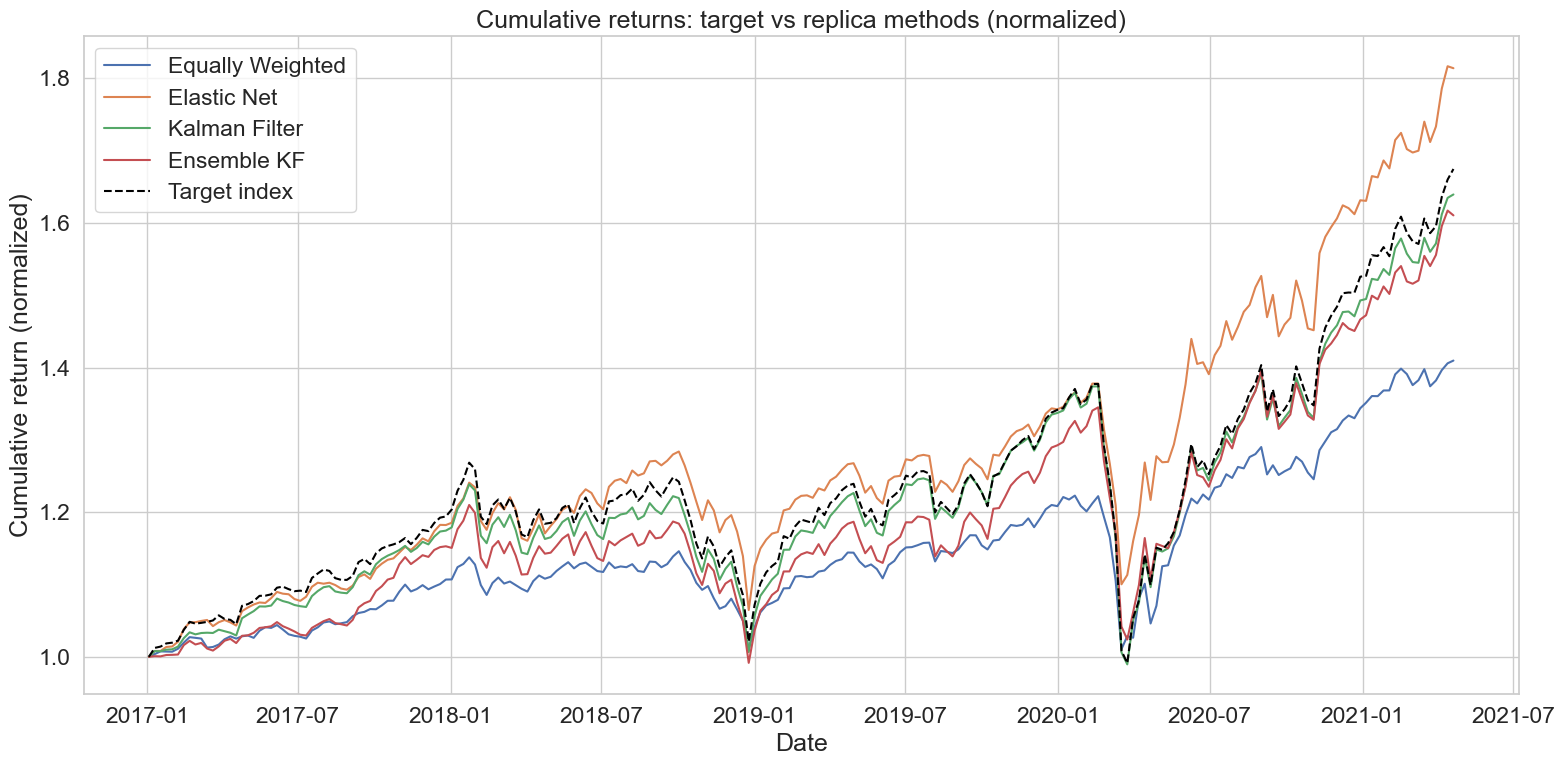

In [56]:
all_results = {
    'Equally Weighted' : results_equal_weighted,
    'Elastic Net'      : results_df_normalized_EN.iloc[0],
    'Kalman Filter'    : best_config_normalized_KF,
    'Ensemble KF'      : result_KFE
}
rep.plot_comparison(all_results)

# Discrete Portfolio Allocation and Transaction Cost Analysis

In this section, we transition from continuous portfolio weights to a **discrete allocation approach**, where portfolio weights are translated into actual positions based on a fixed portfolio value. This is a more realistic scenario, as it accounts for the practical constraints of trading and rebalancing in real markets.

**What these cells do:**
- Convert the continuous weights from each replication model (Elastic Net, Kalman Filter, Ensemble Kalman Filter) into discrete positions, considering a fixed portfolio value and transaction costs.
- Calculate the **Total Expense Ratio (TER)** for each strategy, which represents the annualized transaction costs as a percentage of the portfolio value.
- Display the total and annualized transaction costs, as well as the TER, for each approach.
- Plot and compare the normalized equity curves of the discrete replica portfolios against the target and continuous replica portfolios.

This analysis provides insight into the real-world implementation costs of each replication strategy and highlights the impact of transaction costs and discrete trading on portfolio performance.

In [57]:
# Portfolio value
portfolio_value = 10_000_000 
transaction_cost = 0.0005  # 0.05% transaction costs

Total transaction cost on the dataset: 34886.3256
Annualized average transaction cost: 8062.6175
Total Expense Ratio (TER) per annum: 0.0806%

Position History (first rows):


,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2017-01-03,1,1,1,1,2867,1,388,1,1,1
2017-01-10,1,1,1,1,2853,1,378,1,1,1
2017-01-17,1,1,1,1,2854,1,377,1,1,1
2017-01-24,1,1,1,1,2839,1,373,1,1,1
2017-01-31,1,1,1,1,2729,1,417,1,1,1


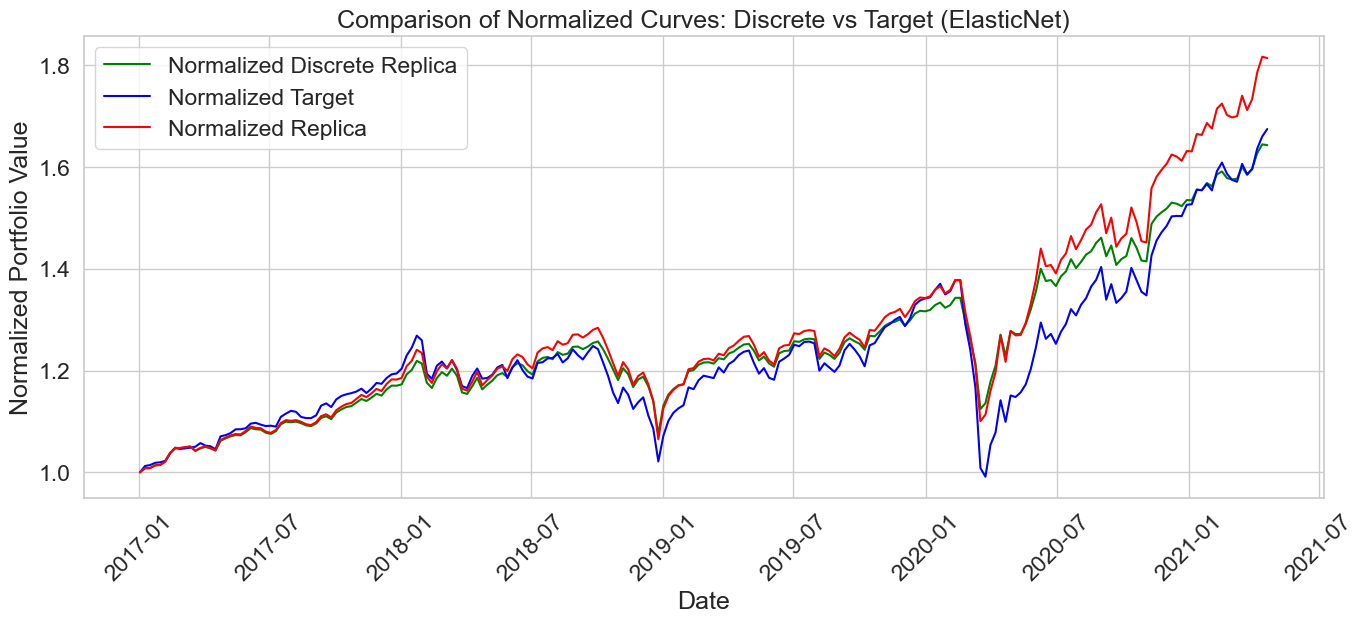

In [58]:
# ElasticNet Portfolio Allocation

total_cost_EN, annual_cost_EN, positions_history_df_EN = rep.compute_discrete_transaction_costs(
    result=results_EN,
    portfolio_value=portfolio_value,
    prices_df=df_underlyings,
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Elastic Net model per annum
TER_EN = annual_cost_EN / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_EN))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_EN))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_EN))
print("\nPosition History (first rows):")
display(positions_history_df_EN.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_EN, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = results_EN['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = results_EN['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (ElasticNet)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Total transaction cost on the dataset: 114599.6481
Annualized average transaction cost: 26485.2520
Total Expense Ratio (TER) per annum: 0.2649%

Position History (first rows):


,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2017-01-03,62,-262,-20,7607,203,162,106,365,2,-28
2017-01-10,92,777,418,-9588,274,134,261,700,-37,188
2017-01-17,584,1267,722,-1875,283,100,289,524,2,329
2017-01-24,-195,182,710,-1403,316,92,315,531,-182,147
2017-01-31,-318,290,707,-1105,314,77,315,543,-163,150


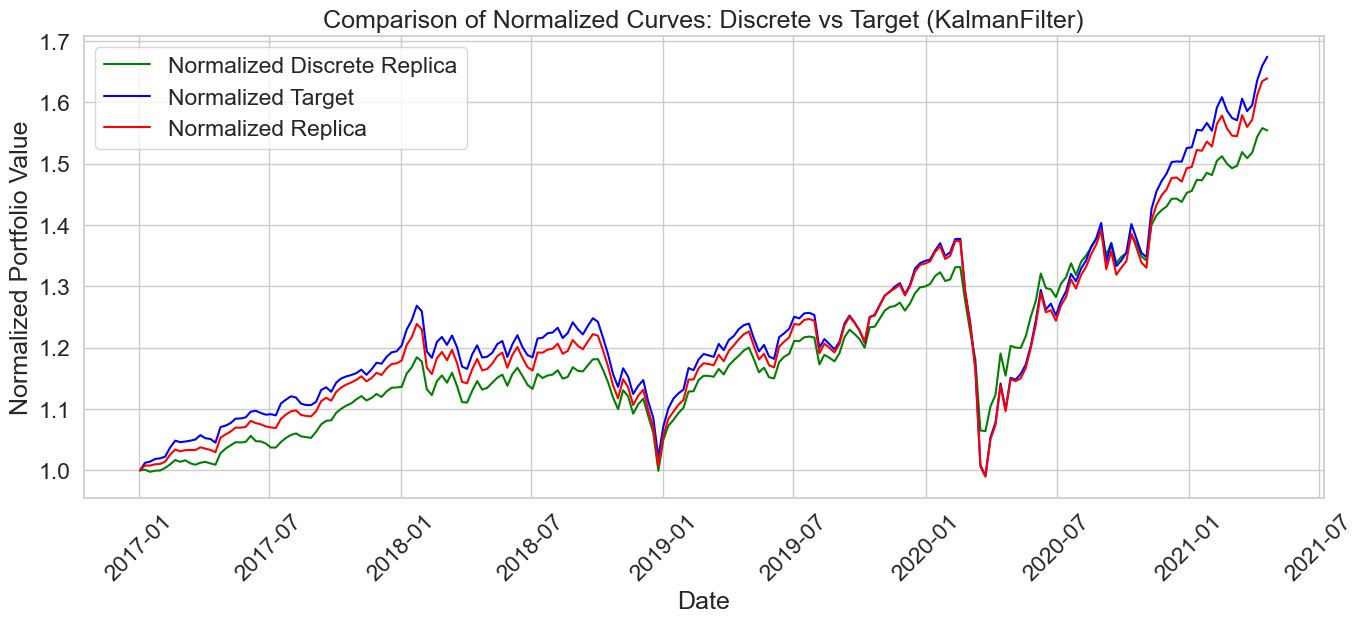

In [59]:
total_cost_KF, annual_cost_KF, positions_history_df_KF = rep.compute_discrete_transaction_costs(
    result=result_KF,
    portfolio_value=portfolio_value,
    prices_df=data[futures_contracts],
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Kalman Filter model per annum
TER_KF = annual_cost_KF / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_KF))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_KF))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_KF))
print("\nPosition History (first rows):")
display(positions_history_df_KF.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_KF, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = result_KF['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = result_KF['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (KalmanFilter)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Total transaction cost on the dataset: 75236.2356
Annualized average transaction cost: 17387.9300
Total Expense Ratio (TER) per annum: 0.1739%

Position History (first rows):


,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
2017-01-03,77,-287,-28,7691,204,161,107,368,4,-23
2017-01-10,77,-286,-27,7954,203,161,104,362,4,-23
2017-01-17,77,-285,-26,7691,203,162,104,371,4,-23
2017-01-24,-1814,-2763,-20,6563,290,144,185,436,-442,-446
2017-01-31,-1821,-2758,-20,6532,290,146,184,434,-442,-446


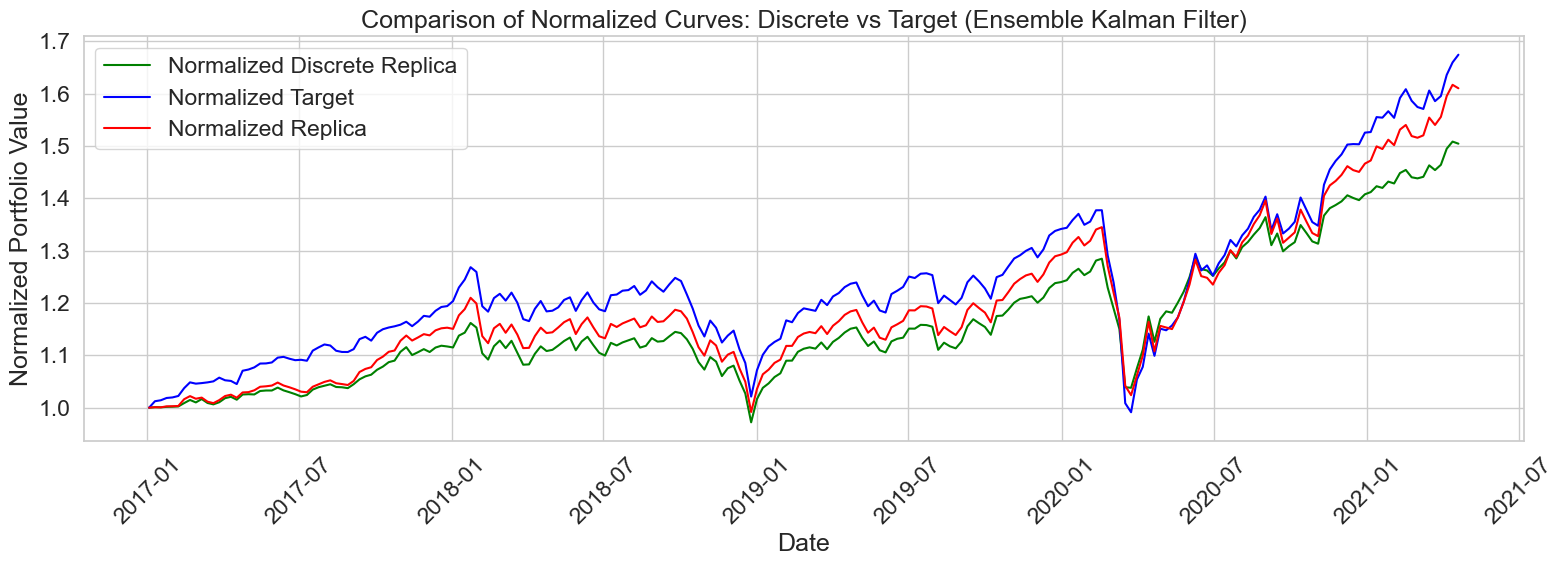

In [60]:
# Ensemble Kalman Filter Portfolio Allocation

total_cost_KFE, annual_cost_KFE, positions_history_df_KFE = rep.compute_discrete_transaction_costs(
    result=result_KFE,
    portfolio_value=portfolio_value,
    prices_df=data[futures_contracts],
    transaction_cost_rate=transaction_cost,
    rebalancing_freq=52
)

# Compute the TER (Total Expense Ratio) for the Ensemble Kalman Filter model per annum
TER_KFE = annual_cost_KFE / portfolio_value * 100  # in percentage

print("Total transaction cost on the dataset: {:.4f}".format(total_cost_KFE))
print("Annualized average transaction cost: {:.4f}".format(annual_cost_KFE))
print("Total Expense Ratio (TER) per annum: {:.4f}%".format(TER_KFE))
print("\nPosition History (first rows):")
display(positions_history_df_KFE.head())

# Calculate the cumulative equity curve for the discrete strategy
cumulative_equity_curve = rep.compute_cumulative_equity_curve(positions_history_df_KFE, data[futures_contracts], portfolio_value)

# Normalize the discrete curve so it starts from 1
normalized_discrete_curve = cumulative_equity_curve / cumulative_equity_curve.iloc[0]

# Retrieve the target curve from the model result
target_curve = result_KFE['cumulative_target']

# If needed, the target can also be normalized (optional); for example:
normalized_target_curve = target_curve / target_curve.iloc[0]

# Retrive the replica curve with the optimized weights
replica_curve = result_KFE['cumulative_replica']
normalized_replica_curve = replica_curve / replica_curve.iloc[0]

plt.figure(figsize=(16, 6))
plt.plot(normalized_discrete_curve.index, normalized_discrete_curve.values, label='Normalized Discrete Replica', color='green')
plt.plot(normalized_target_curve.index, normalized_target_curve.values, label='Normalized Target', color='blue')
plt.plot(normalized_replica_curve.index, normalized_replica_curve.values, label='Normalized Replica', color='red')
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title("Comparison of Normalized Curves: Discrete vs Target (Ensemble Kalman Filter)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Alternative Portfolios: Active Risk Management with Anomaly Detection

In this section, we construct **alternative portfolio replication strategies** that incorporate active risk management by leveraging anomaly detection models. The goal is to identify and respond to predicted stress or crisis periods in the market by temporarily exiting all positions, thereby reducing exposure during adverse conditions.

**What these cells do:**
- Load anomaly detection signals (e.g., from machine learning models) that flag potential stress periods.
- When a stress event is detected, all portfolio weights are set to zero, effectively moving the portfolio to cash for those periods.
- Implement this risk-off overlay both for discrete allocations (rounded positions) and for the original fractional (continuous) weights.
- Compare the performance of these alternative strategies to the standard approach, highlighting the impact of active risk management.

**Key findings:**
- The discrete approach, while more realistic, may introduce additional implementation noise and transaction costs.
- Using the original fractional weights with the anomaly detection overlay generally yields better performance, as it preserves the flexibility and precision of the underlying model while still providing protection during predicted stress periods.

This analysis demonstrates the potential benefits of integrating predictive risk signals into portfolio replication frameworks, allowing for more adaptive and resilient strategies in the face of market turbulence.

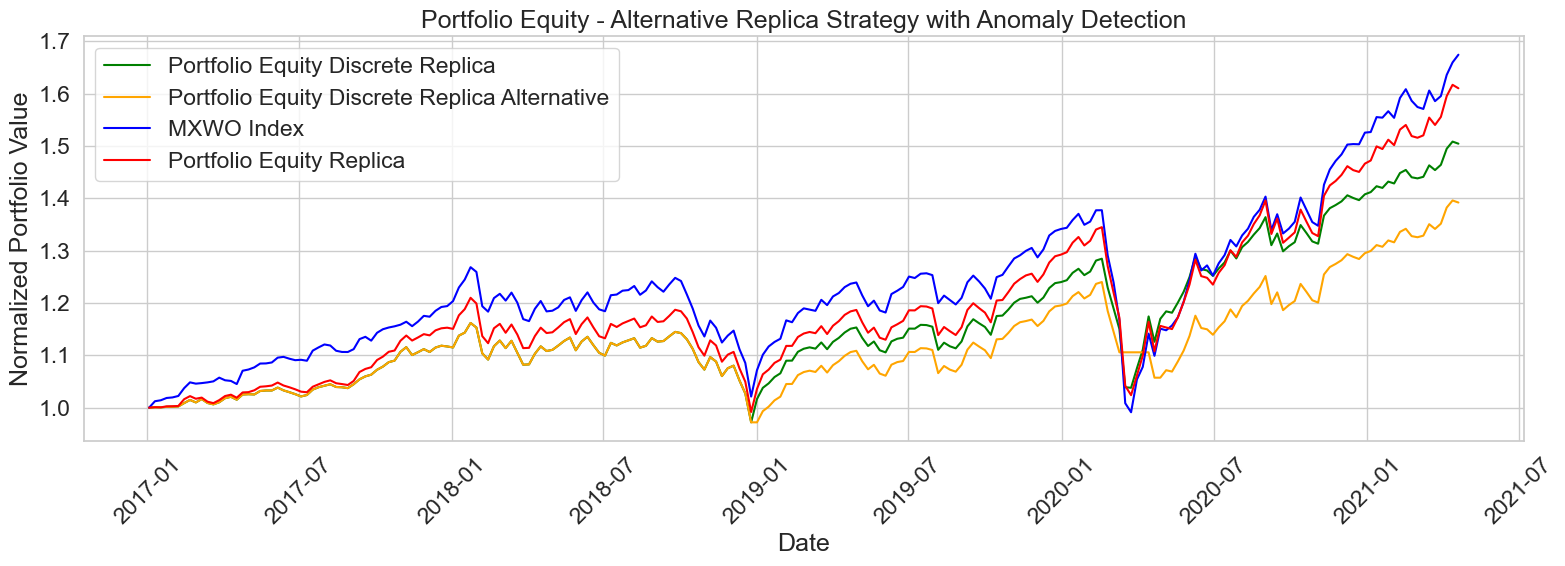

In [61]:
# Load the appropriate anomaly detection dataset and set the date column as the index
if selected_flag == 1:  # Equity portfolio
    anomaly_df = pd.read_csv(
        'anomalyDetectionDatasetMLPOptuna_Equity_USA_F1.csv',
        index_col='Data',
        parse_dates=True
    )
elif selected_flag == 2:  # Bond portfolio
    anomaly_df = pd.read_csv(
        'anomalyDetectionDataset_LSTM_Class_Bond_USA_F1.csv',
        index_col='Data',
        parse_dates=True
    )
elif selected_flag == 3:  # LifeStrategy 80/20 portfolio
    anomaly_df = pd.read_csv(
        'LifeStrategy_LSTM_Cls_predictions.csv',
        index_col='Data',
        parse_dates=True
    )
else:
    raise ValueError("Invalid portfolio selection for anomaly detection dataset.")

# Make copies of the base positions history and result dictionary
base_positions = positions_history_df_KFE.copy()
model_results = result_KFE.copy()

# Align the anomaly detection window to start at the same date as the positions history
start_date = base_positions.index[0]
anomaly_df = anomaly_df.loc[anomaly_df.index >= start_date]

# Create a copy of the positions history for the “alternative” scenario
alt_positions = base_positions.copy()

# Extract the raw weights history from the model results and align its index
raw_weights_df = pd.DataFrame(model_results['weights_history']).copy()
raw_weights_df.index = base_positions.index
raw_weights_df.columns = base_positions.columns  # Ensure the same column names

# Wherever the anomaly detector flags y_pred == 1, zero out all positions
anomaly_dates = anomaly_df.index[anomaly_df['y_pred'] == 1]
alt_positions.loc[anomaly_dates, :] = 0

# Compute the cumulative equity curve for the original (baseline) discrete strategy
cumulative_curve_base = rep.compute_cumulative_equity_curve(
    base_positions,
    data[futures_contracts],
    portfolio_value
)
normalized_curve_base = cumulative_curve_base / cumulative_curve_base.iloc[0]

# Compute the cumulative equity curve for the “alternative” discrete strategy
cumulative_curve_alt = rep.compute_cumulative_equity_curve(
    alt_positions,
    data[futures_contracts],
    portfolio_value
)
normalized_curve_alt = cumulative_curve_alt / cumulative_curve_alt.iloc[0]

# Retrieve and normalize the target (“true”) portfolio performance
target_curve = model_results['cumulative_target']
normalized_target = target_curve / target_curve.iloc[0]

# Retrieve and normalize the replica curve from the model
replica_curve = model_results['cumulative_replica']
normalized_replica = replica_curve / replica_curve.iloc[0]

# Plot all four curves on the same axes for comparison
plt.figure(figsize=(16, 6))
plt.plot(
    normalized_curve_base.index,
    normalized_curve_base.values,
    label=f"{get_selected_portfolio()} Discrete Replica",
    color='green'
)
plt.plot(
    normalized_curve_alt.index,
    normalized_curve_alt.values,
    label=f"{get_selected_portfolio()} Discrete Replica Alternative",
    color='orange'
)
plt.plot(
    normalized_target.index,
    normalized_target.values,
    label=f"{index_name_str}",
    color='blue'
)
plt.plot(
    normalized_replica.index,
    normalized_replica.values,
    label=f"{get_selected_portfolio()} Replica",
    color='red'
)

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title(f"{get_selected_portfolio()} - Alternative Replica Strategy with Anomaly Detection")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Total transaction cost: 97673.8596
Annualized transaction cost: 22573.5142
Total Expense Ratio (TER) per annum: 0.2257%


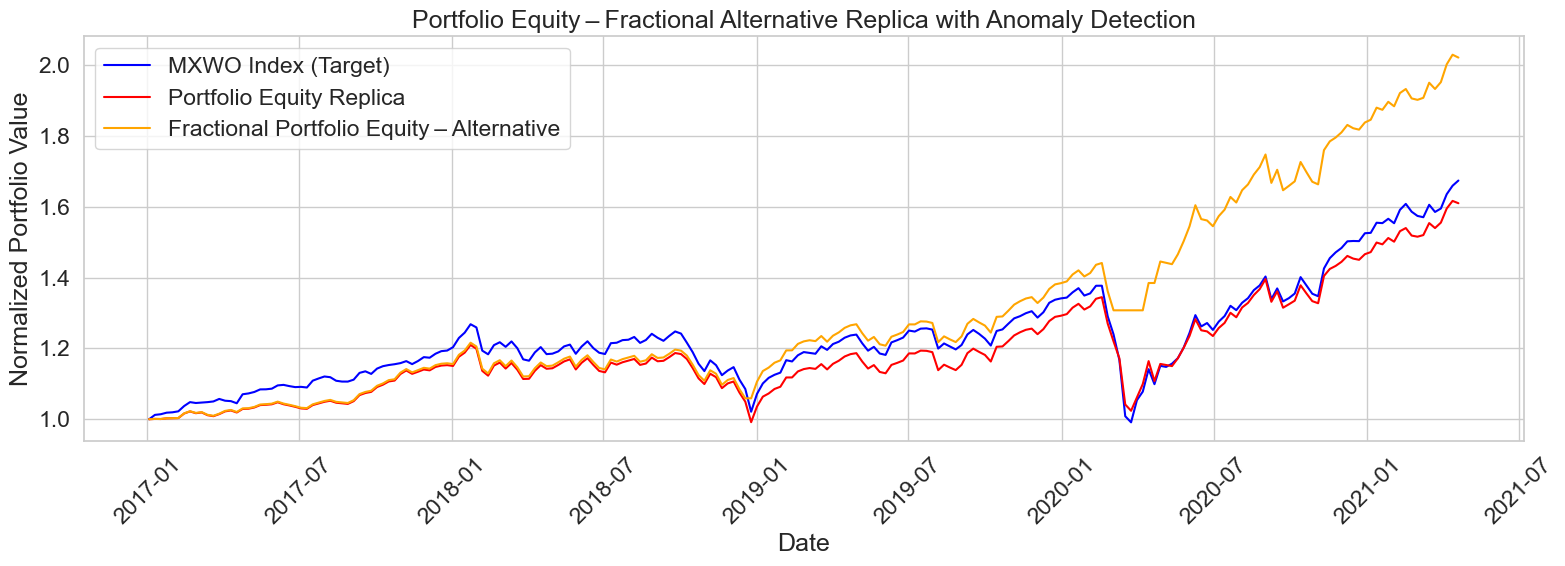

In [62]:
# Build a DataFrame of fractional weights from the model results and align its structure
fractional_weights_df = pd.DataFrame(model_results['weights_history']).copy()
fractional_weights_df.index = base_positions.index
fractional_weights_df.columns = base_positions.columns

# Zero out all fractional weights on dates flagged as anomalies (y_pred == 1)
anomaly_dates = anomaly_df.index[anomaly_df['y_pred'] == 1]
fractional_weights_df.loc[anomaly_dates, :] = 0

# Prepare a price DataFrame, keeping only dates on or after the first weight date
price_series_df = data[futures_contracts].copy()
price_series_df = price_series_df.loc[price_series_df.index >= fractional_weights_df.index[0]]

# Compute daily replica returns and transaction costs using fractional weights
replica_returns, daily_cost, annual_cost_ratio = rep.compute_replica_returns_from_weights_and_prices(
    fractional_weights_df,
    price_series_df,
    transaction_cost
)

# Build the cumulative equity curve from daily replica returns
fractional_equity_cumprod = (1 + replica_returns).cumprod()

# Scale the cost metrics by the total portfolio value
total_transaction_cost = daily_cost * portfolio_value
annualized_transaction_cost = annual_cost_ratio * portfolio_value

# Calculate the annualized Total Expense Ratio (TER) as a percentage
TER_fractional = (annualized_transaction_cost / portfolio_value) * 100

print(f"Total transaction cost: {total_transaction_cost:.4f}")
print(f"Annualized transaction cost: {annualized_transaction_cost:.4f}")
print(f"Total Expense Ratio (TER) per annum: {TER_fractional:.4f}%")

# Retrieve and normalize the target and replica curves from the model results
normalized_target_curve = model_results['cumulative_target'] / model_results['cumulative_target'].iloc[0]
normalized_replica_curve = model_results['cumulative_replica'] / model_results['cumulative_replica'].iloc[0]

# Use the fractional-equity cumulative curve as the "alternative" series
normalized_fractional_equity = fractional_equity_cumprod / fractional_equity_cumprod.iloc[0]

# Plot: target, model replica, and fractional-weights (alternative) equity curves
plt.figure(figsize=(16, 6))
plt.plot(
    normalized_target_curve.index,
    normalized_target_curve.values,
    label=f"{index_name_str} (Target)",
    color='blue'
)
plt.plot(
    normalized_replica_curve.index,
    normalized_replica_curve.values,
    label=f"{get_selected_portfolio()} Replica",
    color='red'
)
plt.plot(
    normalized_fractional_equity.index,
    normalized_fractional_equity.values,
    label=f"Fractional {get_selected_portfolio()} – Alternative",
    color='orange'
)

plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.title(f"{get_selected_portfolio()} – Fractional Alternative Replica with Anomaly Detection")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
